<a href="https://colab.research.google.com/github/shizuo-kaji/TutorialTopologicalDataAnalysis/blob/master/TopologicalDataAnalysisWithPython.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tools for Topological Data Analysis

In this notebook, we will explore:
- The capabilities of TDA for practitioners (Dimensionality reduction, Visualization, Feature extraction, etc.)
- The types of input each method accepts (Point cloud, Image, Time series)
- How different tools can be used in coordination
- Potential new research directions

This notebook is authored by Shizuo Kaji and is maintained [here](https://github.com/shizuo-kaji/TutorialTopologicalDataAnalysis).

## system setup

If your system does not have the necessary libraries, run this cell to install them.

Be patient! It may take a few minutes.

(On some systems, such as Apple Sillicon Mac, you may have to
```
!pip install --no-binary cripser cripser
```
instead of !pip install -q cripser)

In [ ]:
!pip install -q ripser umap-learn kmapper persim PersistenceImages
!pip install -q cripser
!pip install -q tomaster
!pip install -q Boruta gudhi pooch ipywidgets ipympl pot


  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 834.5/834.5 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.8/126.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 781.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.1/175.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.7/515.7 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.6/865.6 kB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 41.8 MB/s eta 0:00:00


In [23]:
import sys
print(sys.executable,sys.version)

/usr/bin/python3 3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]


## function definition

We define functions used later


In [24]:
## load necessary libraries
# standard libraries
%matplotlib inline
#%matplotlib widget

import numpy as np
import scipy as sp
import pandas as pd
import glob, os, re
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, clear_output

# image related libraries
from skimage.filters import threshold_otsu
from scipy.ndimage import distance_transform_edt, convolve
import seaborn as sns
import skimage
from skimage import io
from PIL import Image
# TDA related libraries
import cripser, tcripser
from ripser import ripser
import persim
import gudhi

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

import matplotlib as mpl
mpl.rcParams['text.usetex'] = False

# Gaussian kernel for convolution
def gaussian(h, sigma):
  x = np.arange(-h[0], h[0], 1)
  y = np.arange(-h[1], h[1], 1)
  z = np.arange(-h[2], h[2], 1)
  xx, yy, zz = np.meshgrid(x, y, z)
  return np.exp(-(xx**2 + yy**2 + zz**2) / (2 * sigma**2)).astype(np.float32)

# heatmap of cycles with specified birth-death properties.
def heat_map(img, pd, h=3, sigma=1, min_life=10, max_life=255, min_birth=0, max_birth=255, dimension=0, life_weighted=True, location='birth'):
  if len(img.shape) == 2:
    mx, my = img.shape
    mz = 1
    kernel = gaussian([h, h, 1], sigma)
  else:
    mx, my, mz = img.shape
    kernel = gaussian([h, h, h], sigma)

  selected_cycle = np.zeros((mx, my, mz))
  ppd = pd[pd[:, 0] == dimension]
  ppd = ppd[(min_life < ppd[:, 2] - ppd[:, 1]) & (ppd[:, 2] - ppd[:, 1] < max_life)]
  ppd = ppd[(min_birth < ppd[:, 1]) & (ppd[:, 1] < max_birth)]

  for c in ppd:
    x, y, z = (int(c[3]), int(c[4]), int(c[5])) if location == 'birth' else (int(c[6]), int(c[7]), int(c[8]))
    w = c[2] - c[1] if life_weighted else 1
    selected_cycle[x, y, z] += w

  cycle_conv = convolve(selected_cycle, kernel)
  return np.squeeze(cycle_conv)

# Slice viewer for a 3D image
def explore_slices(data, cmap="gray"):
  from ipywidgets import interact
  N = data.shape[-1]

  @interact(plane=(0, N - 1))
  def display_slice(plane=N // 2):
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.imshow(data[:, :, plane], cmap=cmap)
    plt.show()

  return display_slice

# binary thresholding and distance transform on an image
def dt(img, radius=None, signed=False):
  if radius is not None:
    from skimage.filters import rank
    from skimage.morphology import disk
    bw_img = img >= rank.otsu(img, disk(radius))
  else:
    bw_img = img >= threshold_otsu(img)

  dt_img = distance_transform_edt(bw_img)
  if signed:
    dt_img -= distance_transform_edt(~bw_img)

  return dt_img

# convert GUDHI's diagram to the Ripser style
def gudhi2ripser(diag):
  max_dim = max([p[0] for p in diag])
  return [np.array([p[1:][0] for p in diag if p[0] == i]) for i in range(max_dim+1)]

# convert torch_topological's diagram to the Ripser style
def torch2ripser(ccp):
  return([ccp[i].diagram.cpu().detach().numpy() for i in range(len(ccp))])

## remark on google colab

In [ ]:
## Here's an example of how to manage files on Google Colab
# Alternatively, you can simply use the "Files" tab on the left to download/upload files.

# from google.colab import files

# # List files in the current directory
# !ls

# # Upload files from your local machine
# uploaded = files.upload()

# # Download a specific file to your local machine
# files.download('kepler-mapper-output.html')

# Feature Extraction from Different Data Types

Persistent Homology (PH) assigns feature vectors to various types of data.
This process enables the extraction of topological features that can be used for further analysis and machine learning tasks.

## Point cloud

In [ ]:
# Sampling points from sphere and cube
def sample_sphere(n, dim=3, radius=1,sigma=0.5):
    X = np.random.rand(n, dim) - 0.5
    X = X / np.sqrt(np.sum(X**2, axis=1, keepdims=True))
    X *= radius
    X += np.random.normal(scale=sigma, size=(len(X), dim))
    #X += np.random.uniform(-1, 1, 3)
    return X

def sample_cube(n, dim=3, radius=1,sigma=0.5):
    X = 2 * np.random.rand(n, dim) - 1
    X *= radius
    X += np.random.normal(scale=sigma, size=(len(X), dim))
    #X += np.random.uniform(-1, 1, 3)
    return X


### first example

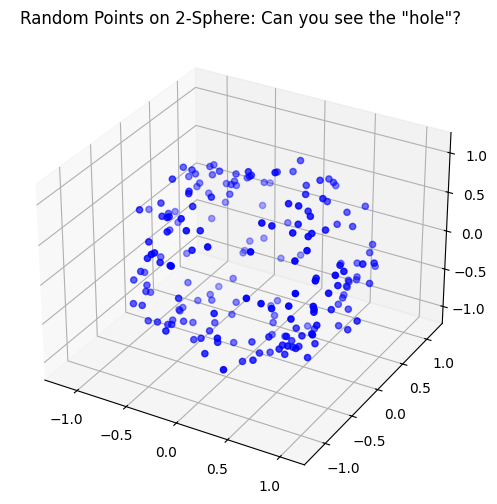

In [ ]:
## create random data on 2-sphere
X = sample_sphere(200, dim=3, radius=1, sigma=0.1)

# plot the points on the 2-sphere
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c='b', marker='o')
ax.set_title('Random Points on 2-Sphere: Can you see the "hole"?')
plt.show()

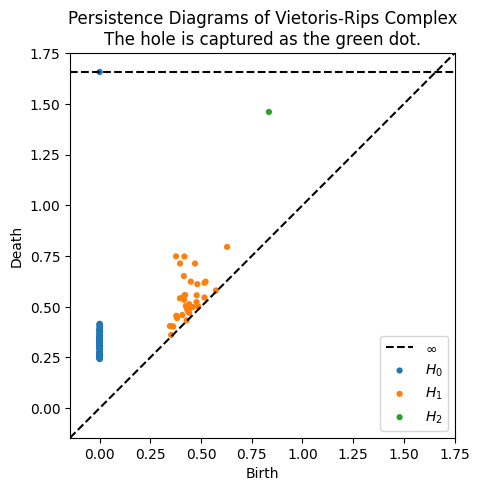

In [ ]:
## compute persistent homology (PH) of the Vietoris-Rips (VR) complex and plot the persistence diagram (PD)
## VR-complex has a huge number of simplices. So the maximum number of points that is tractable is in the order of 1000.
## To reduce the computational complexity, you can compute an approximated PH by setting, e.g., "n_perm=100" (sub-sampling 100 points which are far apart).
diag = ripser(X, maxdim=2, n_perm=100)['dgms']

# Plot persistence diagrams
fig, ax = plt.subplots(figsize=(10, 5))
persim.plot_diagrams(diag, ax=ax)
ax.set_title('Persistence Diagrams of Vietoris-Rips Complex\nThe hole is captured as the green dot.')
plt.show()

#### Vectorisation of persistence diagram

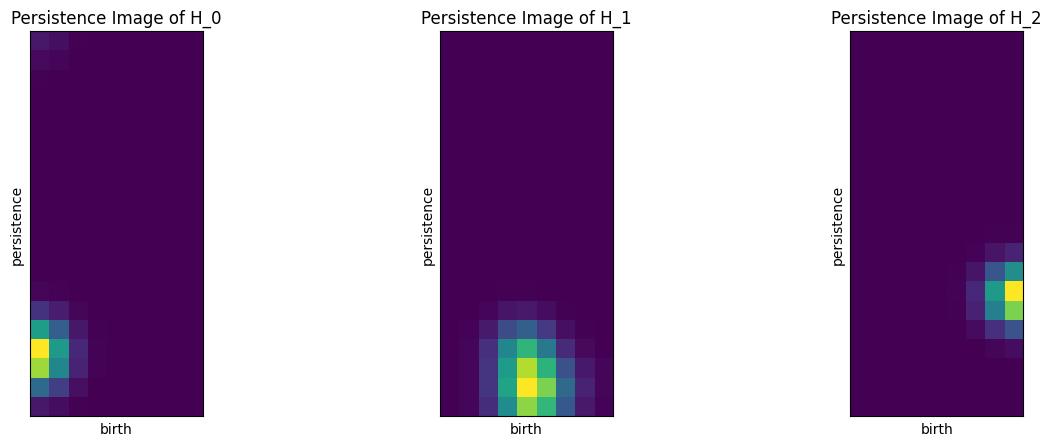

In [ ]:
# Persistence Image converts the persistence diagram into a fixed-length vector
# which is convenient for downstream tasks using standard machine learning techniques
# There is a downside: you have to choose hyperparameters:
# look at https://persim.scikit-tda.org/en/latest/reference/stubs/persim.PersistenceImager.html
min_birth, max_death = 0, 2
dclip = [np.clip(d, min_birth, max_death) for d in diag]
pimgr = persim.PersistenceImager(pixel_size=0.1, kernel_params={'sigma': [[0.01, 0.0], [0.0, 0.01]]})
pimgr.fit(dclip, skew=True)
pimgs = pimgr.transform(dclip, skew=True, n_jobs=-1)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    pimgr.plot_image(pimgs[i], axs[i])
    axs[i].set_title("Persistence Image of H_{}".format(i))
plt.show()


#### different types of complexes

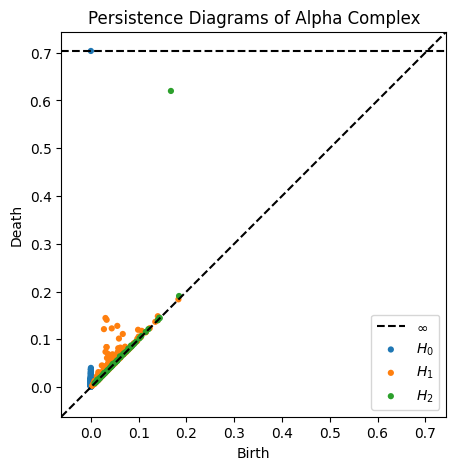

In [ ]:
## from a point cloud, we can construct different complexes.
# The choice affects performance and the result, so we have to give a careful consideration
# Let's see an example of alpha complex.

simplex_tree = gudhi.AlphaComplex(points=X).create_simplex_tree()
diag = simplex_tree.persistence()

## We observe a notable difference in H_1 compared to the result of the VR complex above
#gudhi.plot_persistence_diagram(diag, legend=True)
di = gudhi2ripser(diag)
fig, ax = plt.subplots(figsize=(10, 5))
persim.plot_diagrams(di, ax=ax)
ax.set_title('Persistence Diagrams of Alpha Complex')
plt.show()

#!pip install cechmate  ## C++ compilers are required on the system
#import cechmate as cm
#alpha = cm.Alpha()
#filtration = alpha.build(X)
#dgmsalpha = alpha.diagrams(filtration)
#persim.plot_diagrams(dgmsalpha)

### 2D point cloud with three clusters

In [34]:
from scipy.spatial import distance_matrix
from scipy.ndimage import distance_transform_edt
from ipywidgets import interact, FloatSlider

# Compute (inefficiently!) Vietoris-Rips complex (edges, triangles, tetrahedra) for given epsilon
def vietoris_rips_complex(points, epsilon):
    dist_matrix = distance_matrix(points, points)
    num_points = len(points)

    # 1-simplices (edges)
    edges = [(i, j) for i in range(num_points) for j in range(i+1, num_points) if dist_matrix[i, j] <= epsilon]

    # 2-simplices (triangles)
    triangles = [
        (i, j, k)
        for i in range(num_points)
        for j in range(i+1, num_points)
        for k in range(j+1, num_points)
        if dist_matrix[i, j] <= epsilon and dist_matrix[i, k] <= epsilon and dist_matrix[j, k] <= epsilon
    ]

    # 3-simplices (tetrahedra)
    tetrahedra = [
        (i, j, k, l)
        for i in range(num_points)
        for j in range(i+1, num_points)
        for k in range(j+1, num_points)
        for l in range(k+1, num_points)
        if (
            dist_matrix[i, j] <= epsilon and dist_matrix[i, k] <= epsilon and dist_matrix[i, l] <= epsilon and
            dist_matrix[j, k] <= epsilon and dist_matrix[j, l] <= epsilon and dist_matrix[k, l] <= epsilon
        )
    ]

    return edges, triangles, tetrahedra

# Plot the point cloud and the Vietoris-Rips complex
def plot_vietoris_rips(points, epsilon):
    edges, triangles, tetrahedra = vietoris_rips_complex(points, epsilon)

    # Compute distance transform image
    distance_transform = compute_distance_transform(points)

    plt.figure(figsize=(8, 8))

    # Plot distance transform image
    plt.imshow(distance_transform, origin="lower", cmap="viridis", extent=[0, 1, 0, 1], alpha=0.6)

    # Plot points
    for point in points:
        plt.scatter(*point, color='blue', s=50)

    # Plot edges
    for i, j in edges:
        plt.plot(
            [points[i][0], points[j][0]],
            [points[i][1], points[j][1]],
            color='gray',
            linestyle='--',
            linewidth=1
        )

    # Plot triangles
    for i, j, k in triangles:
        plt.fill(
            [points[i][0], points[j][0], points[k][0]],
            [points[i][1], points[j][1], points[k][1]],
            color='lightblue',
            alpha=0.5
        )

    # Plot tetrahedra
    for i, j, k, l in tetrahedra:
        x_coords = [points[i][0], points[j][0], points[k][0], points[l][0]]
        y_coords = [points[i][1], points[j][1], points[k][1], points[l][1]]
        plt.fill(x_coords, y_coords, color='lightgreen', alpha=0.3)

    plt.title(f"Vietoris-Rips Complex (epsilon = {epsilon})")
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

# Compute distance transform image
def compute_distance_transform(points, grid_size=100):
    grid = np.zeros((grid_size, grid_size))
    for x, y in points:
        grid[int(y * (grid_size - 1)), int(x * (grid_size - 1))] = 1
    distance_transform = distance_transform_edt(1 - grid)
    return distance_transform


# Interactive widget for Vietoris-Rips complex visualization
def interactive_vietoris_rips(points=None, num_pts = 10, e_min=0.0, e_max=1.0):
    if points is None:
      points = sample_sphere(num_pts, dim=2, radius=0.3,sigma=0)+0.5

    interact(
        lambda epsilon: plot_vietoris_rips(points, epsilon),
        epsilon=FloatSlider(value=0.0, min=e_min, max=e_max, step=(e_max-e_min)/20, description='epsilon')
    )


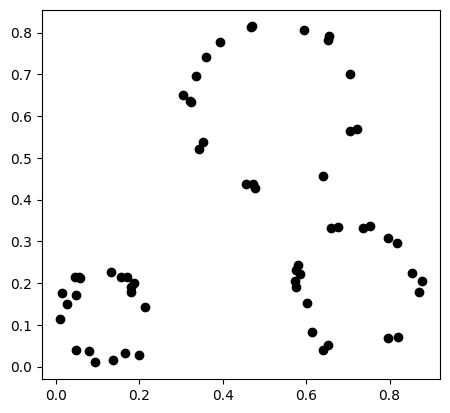

In [37]:
# Three circles: three clusters (connected components), each with non-trivial topology (circle)
sigma=0.1
pts0 = sample_sphere(20, dim=2, radius=1, sigma=sigma)
pts1 = sample_sphere(20, dim=2, radius=2, sigma=sigma)+np.array([4,5])
pts2 = sample_sphere(20, dim=2, radius=1.5, sigma=sigma)+np.array([6,0.7])
pts = 0.1*(np.vstack([pts0,pts1,pts2])+np.array([1.2,1.2]))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_aspect('equal')
plt.scatter(pts[:,0], pts[:,1],c="k")
#plt.axis("off")
plt.show()


In [38]:
interactive_vietoris_rips(pts, e_min=0.0, e_max=0.5)

interactive(children=(FloatSlider(value=0.0, description='epsilon', max=0.5, step=0.025), Output()), _dom_clas…

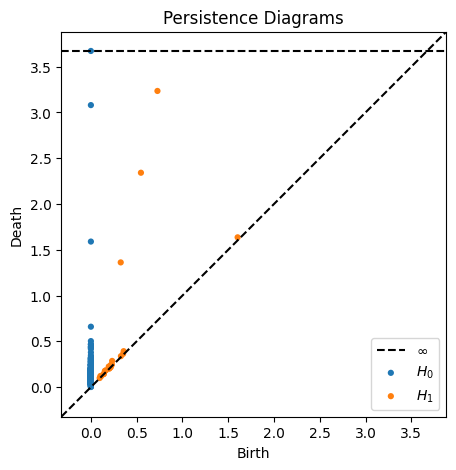

In [ ]:
# three prominent H0 cycles correspond to the three clusters
# and three prominent H1 cycles correspond to the three circles
from gudhi.dtm_rips_complex import DTMRipsComplex

rips = gudhi.RipsComplex(points=pts)
rips = DTMRipsComplex(points=pts) # Distance-To-Measure VR-complex is more robust against noise
st_rips = rips.create_simplex_tree(2)
diag = st_rips.persistence()
di = gudhi2ripser(diag)
fig, ax = plt.subplots(figsize=(10, 5))
persim.plot_diagrams(di, ax=ax)
ax.set_title('Persistence Diagrams')
plt.show()


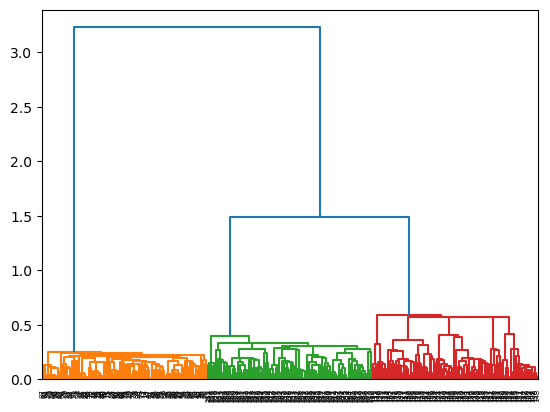

In [ ]:
# PH0 corresponds to hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(pts, 'single')
dn = dendrogram(Z,color_threshold=1.1)
plt.show()

### Distance between persistent diagrams

Persistent diagrams live in a metric space.
So we can measure similarity between two samples.

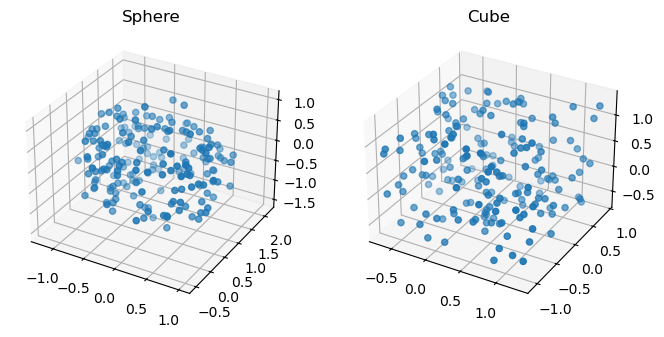

In [ ]:
## create point clouds from sphere and cube and compute pairwise bottleneck distance of PH
n = 5   # number of spheres (cubes). In total, we'll have 2n sets of point clouds.
spheres = [sample_sphere(200) for _ in range(n)]
cubes = [sample_cube(200) for _ in range(n)]
X = spheres + cubes
Y = [0] * n + [1] * n

## Plot the point clouds: for human eyes, it is not very easy to distinguish 3d point clouds
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(spheres[0][:, 0], spheres[0][:, 1], spheres[0][:, 2])
ax.set_title('Sphere')
ax = fig.add_subplot(122, projection='3d')
ax.scatter(cubes[0][:, 0], cubes[0][:, 1], cubes[0][:, 2])
ax.set_title('Cube')
plt.show()

# compute PH and distance
pd = [ripser(point_cloud, maxdim=2, n_perm=100)['dgms'][2] for point_cloud in X]

D = np.zeros((2 * n, 2 * n))
for i in range(2 * n - 1):
    for j in range(i + 1, 2 * n):
        D[i, j] = persim.bottleneck(pd[i], pd[j])


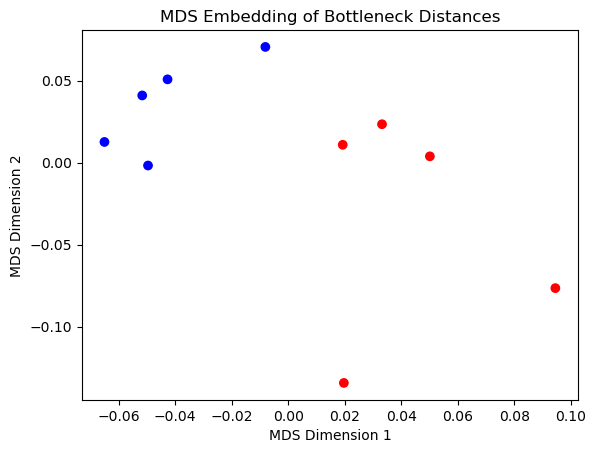

In [ ]:
## Bottleneck distance discern spheres from cubes
# We obtain the distance matrix for point clouds, and thus, a finite metric space with 2n points.
# For visualisation, we use Multi-dimensional scaling, a method to embed a finite metric space into a Euclidean space
# Blue dots represent cubes, red dots represent spheres
from sklearn.manifold import MDS

# Ensure the distance matrix is symmetric
D_symmetric = D + D.T

# Apply MDS
mds = MDS(n_components=2, dissimilarity='precomputed')
X_mds = mds.fit_transform(D_symmetric)

# Plot the results
col = ['r', 'b']
plt.scatter(X_mds[:, 0], X_mds[:, 1], c=[col[y] for y in Y])
plt.title('MDS Embedding of Bottleneck Distances')
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.show()

#### Remark on Bottleneck and p-Wasserstein distances

In [ ]:
# We have two parameters for Wasserstein distance: the exponent p and the metric for the underlying space.
import gudhi,gudhi.hera,gudhi.wasserstein,persim
# one-point in a plane
X,Y =np.array([[0., 0.01]]), np.array([[0., 13.],[0.,12.]])
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(121)
persim.plot_diagrams(X, ax=ax)
ax = fig.add_subplot(122)
persim.plot_diagrams(Y, ax=ax)

print("Distances")
print("Bottleneck (GUDHI-hera) with L-infty metric:", gudhi.bottleneck_distance(X,Y))
print("Bottleneck (persim) with L-infty metric:", persim.bottleneck(X,Y))
#print(gudhi.wasserstein.wasserstein_distance(X, Y, order=1, internal_p=2)) ## requires pot
print("2-Wasserstein (GUDHI-hera) with L-infty metric:", gudhi.hera.wasserstein_distance(X, Y, order=1, internal_p=np.inf))
print("2-Wasserstein (GUDHI-hera) with L2 Euclidean metric:", gudhi.hera.wasserstein_distance(X, Y, order=1, internal_p=2))
print("99-Wasserstein (GUDHI-hera) with L2 Euclidean metric:", gudhi.hera.wasserstein_distance(X, Y, order=99, internal_p=2))
print("99-Wasserstein (GUDHI-hera) with L-infty metric (approx. Bottleneck distance):", gudhi.hera.wasserstein_distance(X, Y, order=99, internal_p=np.inf))



Distances
Bottleneck (GUDHI-hera) with L-infty metric: 6.499999999999999
Bottleneck (persim) with L-infty metric: 6.5
2-Wasserstein (GUDHI-hera) with L-infty metric: 12.504999999999999
2-Wasserstein (GUDHI-hera) with L2 Euclidean metric: 17.684740597475553
99-Wasserstein (GUDHI-hera) with L2 Euclidean metric: 9.192421749823405
99-Wasserstein (GUDHI-hera) with L-infty metric (approx. Bottleneck distance): 6.500023754826838


### point cloud in an ambient metric space (graph)

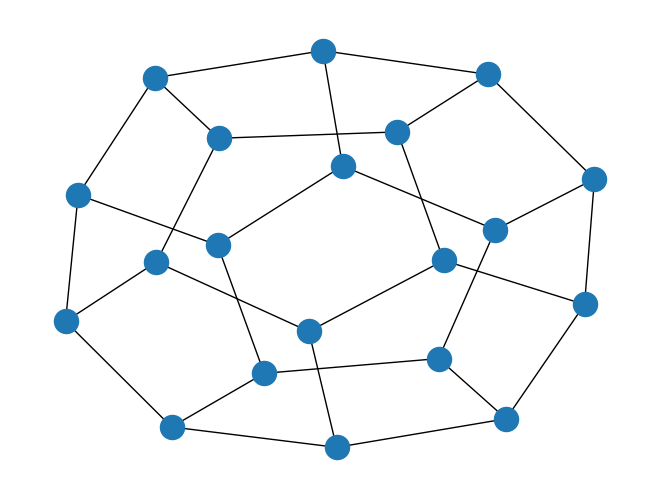

In [ ]:
## VR complex can also be constructed from an abstract distance matrix, not necessarily from a point cloud in a Euclidean space.
# We give an example of a graph distance
import networkx as nx
G = nx.dodecahedral_graph()
nx.draw(G)
D = np.array(nx.floyd_warshall_numpy(G))  # distance matrix
plt.show()


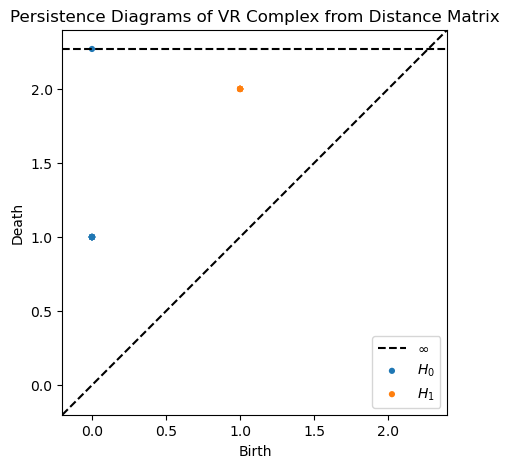

In [ ]:
# Compute persistent homology of the distance matrix
diag = ripser(D, distance_matrix=True)['dgms']

# Plot persistence diagrams
fig, ax = plt.subplots(figsize=(10, 5))
persim.plot_diagrams(diag, ax=ax)
ax.set_title('Persistence Diagrams of VR Complex from Distance Matrix')
plt.show()



### A direction for new research

An interesting question is: for a set of point clouds (or images), we can first compute PD for each point cloud and then compute the distance matrix of PDs. PH of the distance matrix defines a feature for "a set of point clouds". Do we have a practical application?

For example, we have multiple measurements for objects from each class, and each measurement yields PH. In this case, "PH of PD" provides a collective feature for the objects belonging to the class.


### Trajectory of cycles in a sequence of PD

In [ ]:
# sample from Figure 8
def create_figure8(num_samples=200):
  t = np.linspace(0, 2*np.pi, num=num_samples)
  X = np.stack((np.sqrt(2)*np.cos(t) / (np.sin(t)**2+1), np.sqrt(2)*np.cos(t)*np.sin(t) / (np.sin(t)**2+1))).T
  X += 0.1*np.random.random(X.shape)
  return(X)

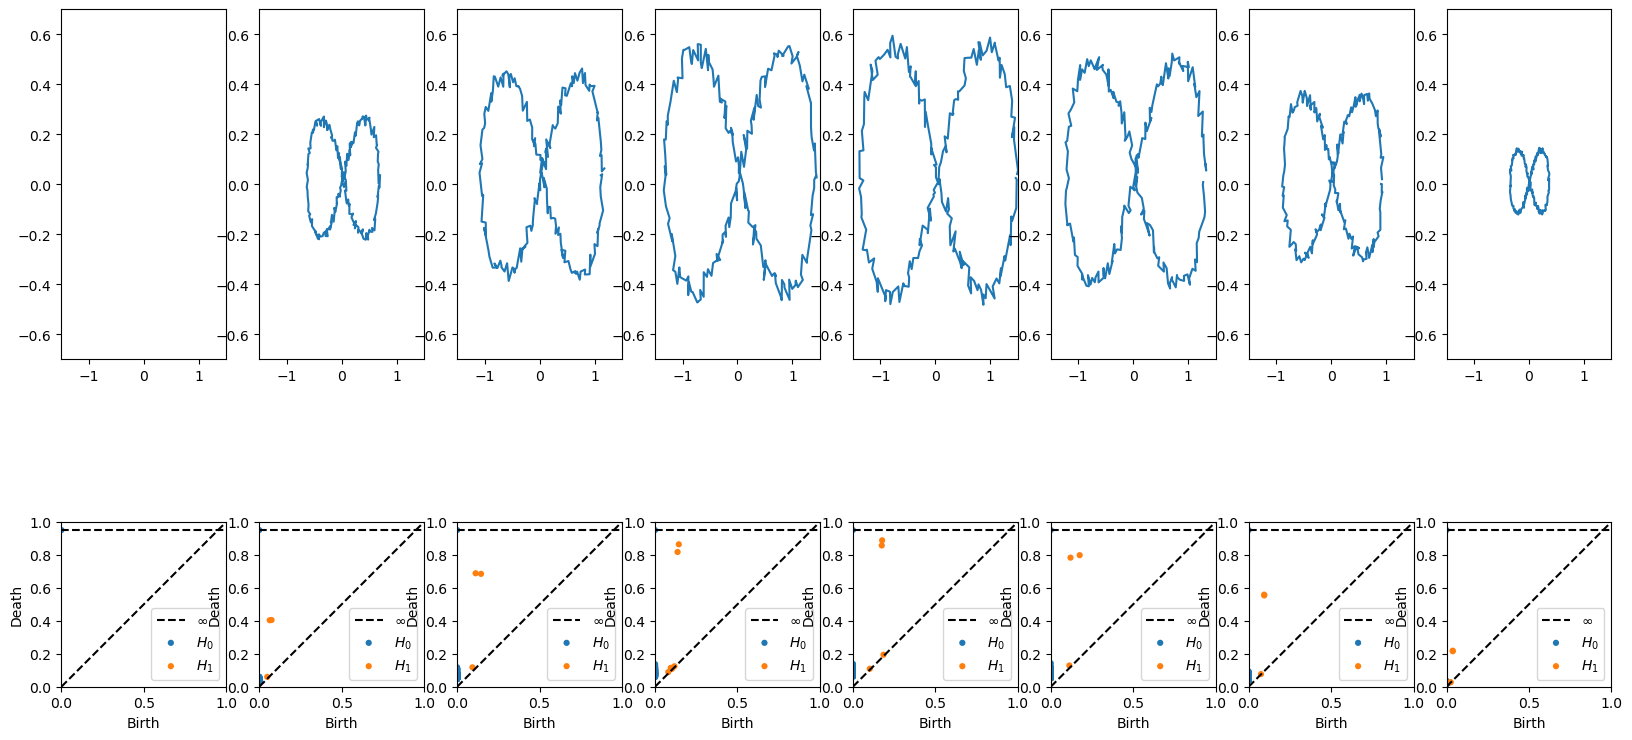

In [ ]:
# create a sequence of figure8 with varying scale and compute their PD
Xs = []
diags = []
frames = 30
a = frames / 2

for fr in range(frames):
  scale = (a**2 - (fr - a)**2) / (a**2)
  X = create_figure8() * scale
  Xs.append(X)
  diags.append(ripser(X, maxdim=1, n_perm=100)['dgms'])

# plot some of the samples
num_disp = 7
fig, axs = plt.subplots(2, num_disp, figsize=(20, 10))

for i, (x, dg) in enumerate(zip(Xs[::frames // num_disp], diags[::frames // num_disp])):
  axs[0, i].set_xlim(-1.5, 1.5)
  axs[0, i].set_ylim(-0.7, 0.7)
  axs[0, i].plot(*x.T)
  persim.plot_diagrams(dg, xy_range=(0, 1, 0, 1), ax=axs[1, i])

plt.show()


In [ ]:
# function to match cycles between adjacent frames and plot their trajectories
import matplotlib.colors as colors
import matplotlib.cm as cm

def cycle_trajectory(diags, dim):
  fig, ax = plt.subplots()
  plt.xlim(0, 0.3)
  plt.ylim(0, 1)
  usercmap = plt.get_cmap('jet')
  cNorm = colors.Normalize(vmin=0, vmax=len(diags))
  scalarMap = cm.ScalarMappable(norm=cNorm, cmap=usercmap)

  for i in range(len(diags) - 1):
    D1 = diags[i][dim]
    D2 = diags[i + 1][dim]
    d, M = persim.wasserstein(D1, D2, matching=True)
    for m in M:
      m0 = int(m[0])  # matched ids
      m1 = int(m[1])
      if -1 < m0 < len(D1) and -1 < m1 < len(D2):
        plt.plot([D1[m0][0], D2[m1][0]], [D1[m0][1], D2[m1][1]], 'k-', lw=1)
        plt.plot(*D2[m1], 'o', color=scalarMap.to_rgba(i))

  cax = fig.add_axes([0.92, 0.1, 0.03, 0.8])
  plt.colorbar(scalarMap, cax=cax, label="time")
  plt.xlabel("birth")
  plt.ylabel("life")
  plt.show()

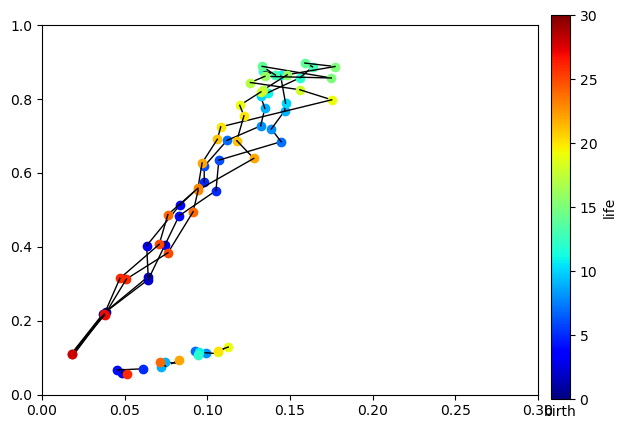

In [ ]:
## Visualise H_1 trajectory
# Blue: early frame => Red: late frame
# We can observe that two cycles emerge and grow (to longer lifetime) and then follow the path back to finally disappear.
# The points with low lifetime are noise.
cycle_trajectory(diags,dim=1)

## Image

A greyscale image is a function on the plane.

The cubical complex is constructed to compute PH.

### Cubical complex

[dim,birth,death,x1,y1,z1,x2,y2,z2]: V-construction
[[0 0 1 3 0 0 3 1 0]
 [0 0 9 3 4 0 0 0 0]
 [1 1 2 1 2 0 1 3 0]]
[dim,birth,death,x1,y1,z1,x2,y2,z2]: T-construction
[[0 0 1 3 0 0 3 1 0]
 [0 0 9 4 5 0 0 0 0]
 [1 1 2 1 2 0 1 3 0]]


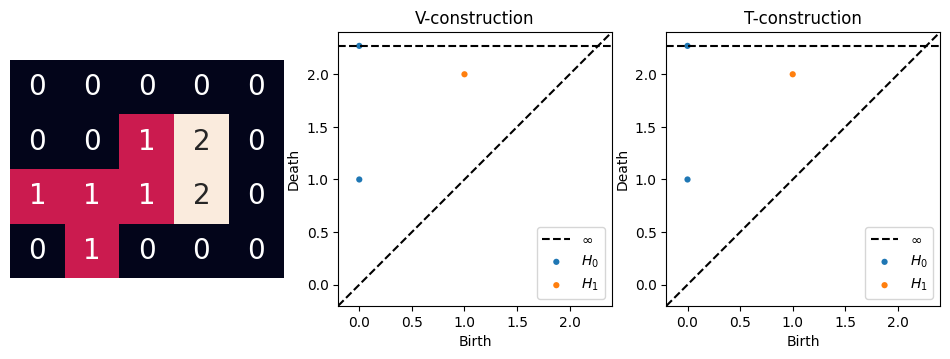

In [ ]:
## simple example
import cripser, tcripser
import persim

# define a 2D array
simple_img=np.array([[0,0,0,0,0],
                      [0,0,1,2,0],
                      [1,1,1,2,0],
                      [0,1,0,0,0]])

# plot the array
fig,axs = plt.subplots(1,3,figsize=(12,4))
sns.heatmap(simple_img, annot=True, square=True, yticklabels=False, xticklabels=False, annot_kws={"fontsize":20}, cbar=False, ax=axs[0])

# compute PH of the 2D array: there are two major ways to construct a cubical complex from the array
# in this particular example, we do not see any difference in the persistence diagram
pd = cripser.computePH(simple_img) # V-construction
pdt = tcripser.computePH(simple_img) # T-construction

# each line contains (dim,birth,death,x1,y1,z1,x2,y2,z2), where (x1,y1,z1) is the location of the creator cell of the cycle and (x2,y2,z2) is the location of the destroyer cell of the cycle"
print("[dim,birth,death,x1,y1,z1,x2,y2,z2]: V-construction")
print(np.where(pd<9, pd, 9).astype(int)) # replace infty with 9 for printing
print("[dim,birth,death,x1,y1,z1,x2,y2,z2]: T-construction")
print(np.where(pdt<9, pdt, 9).astype(int)) # replace infty with 9 for printing

# plot persistence diagram
persim.plot_diagrams([p[:,1:3] for p in [pd[pd[:,0] == i] for i in range(2)]], ax=axs[1], title='V-construction')
persim.plot_diagrams([p[:,1:3] for p in [pdt[pdt[:,0] == i] for i in range(2)]], ax=axs[2], title='T-construction')
plt.show()


In [ ]:
# visualise the V-construction
from ipywidgets import interact, FloatSlider

# Compute Cubical Complex for a greyscale image
def cubical_complex(image, threshold):
    # Binary thresholding
    binary_image = (image <= threshold).astype(int)

    # Find active cells (pixels that meet the threshold)
    active_cells = np.argwhere(binary_image == 1)

    # Cubes (vertices, edges, squares)
    vertices = [(x, y) for x, y in active_cells]

    edges = []
    for x, y in active_cells:
        # Check right neighbor
        if x + 1 < image.shape[0] and binary_image[x + 1, y] == 1:
            edges.append(((x, y), (x + 1, y)))
        # Check bottom neighbor
        if y + 1 < image.shape[1] and binary_image[x, y + 1] == 1:
            edges.append(((x, y), (x, y + 1)))

    squares = []
    for x, y in active_cells:
        if (x + 1 < image.shape[0] and y + 1 < image.shape[1] and
            binary_image[x + 1, y] == 1 and binary_image[x, y + 1] == 1 and binary_image[x + 1, y + 1] == 1):
            squares.append(((x, y), (x + 1, y), (x, y + 1), (x + 1, y + 1)))

    return vertices, edges, squares

# Plot Cubical Complex
def plot_cubical_complex(image, threshold):
    vertices, edges, squares = cubical_complex(image, threshold)

    plt.figure(figsize=(8, 8))

    # Plot the image
    plt.imshow(image, cmap="gray", origin="lower", extent=[0, image.shape[1], 0, image.shape[0]])

    # Annotate pixel values
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            plt.text(y + 0.5, x + 0.5, f"{image[x, y]:.2f}", color="red",
                     ha="center", va="center", fontsize=8, bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white", alpha=0.7))

    # Plot vertices
    for x, y in vertices:
        plt.scatter(y + 0.5, x + 0.5, color="blue", s=300)

    # Plot edges
    for (x1, y1), (x2, y2) in edges:
        plt.plot([y1 + 0.5, y2 + 0.5], [x1 + 0.5, x2 + 0.5], color="red", linewidth=2)

    # Plot squares
    for (x1, y1), (x2, y2), (x3, y3), (x4, y4) in squares:
        plt.fill(
            [y1 + 0.5, y2 + 0.5, y4 + 0.5, y3 + 0.5],
            [x1 + 0.5, x2 + 0.5, x4 + 0.5, x3 + 0.5],
            color="green",
            alpha=0.3,
        )

    plt.title(f"Cubical Complex (threshold = {threshold})")
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

# Interactive widget for Cubical Complex visualization
def interactive_cubical_complex(image=None):
    if image is None:
      size = 5
      image = np.random.rand(size, size)
    interact(
        lambda threshold: plot_cubical_complex(image, threshold),
        threshold=FloatSlider(value=0.0, min=0, max=image.max(), step=image.max()/10, description='Threshold')
    )

interactive_cubical_complex(simple_img)


interactive(children=(FloatSlider(value=0.0, description='Threshold', max=2.0, step=0.2), Output()), _dom_clas…

[dim,birth,death,x1,y1,z1,x2,y2,z2]: V-construction
[[0 0 1 3 0 0 3 1 0]
 [0 0 9 3 4 0 0 0 0]
 [1 1 2 2 2 0 1 3 0]]
[dim,birth,death,x1,y1,z1,x2,y2,z2]: T-construction
[[0 0 9 4 5 0 0 0 0]
 [1 0 2 0 2 0 1 3 0]]


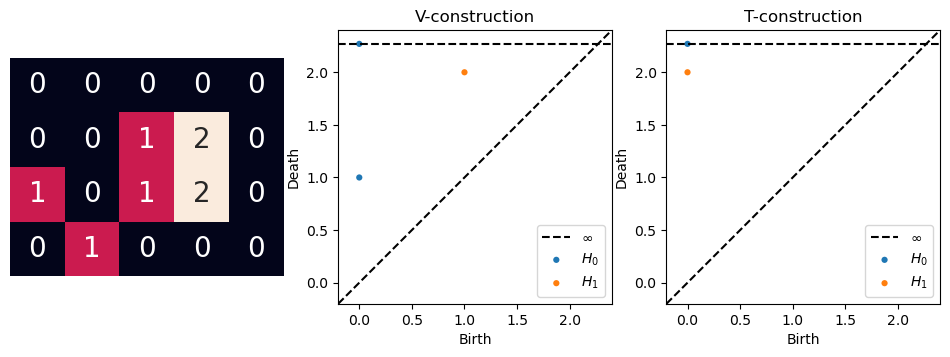

In [ ]:
## simple example showing the difference between V- and T- constructions

# define a 2D array
simple_img=np.array([[0,0,0,0,0],
                      [0,0,1,2,0],
                      [1,0,1,2,0],
                      [0,1,0,0,0]])

# plot the array
fig,axs = plt.subplots(1,3,figsize=(12,4))
sns.heatmap(simple_img, annot=True, square=True, yticklabels=False, xticklabels=False, annot_kws={"fontsize":20}, cbar=False, ax=axs[0])

# compute PH of the 2D array
pd = cripser.computePH(simple_img) # V-construction
pdt = tcripser.computePH(simple_img) # T-construction

# each line contains (dim,birth,death,x1,y1,z1,x2,y2,z2), where (x1,y1,z1) is the location of the creator cell of the cycle and (x2,y2,z2) is the location of the destroyer cell of the cycle"
print("[dim,birth,death,x1,y1,z1,x2,y2,z2]: V-construction")
print(np.where(pd<9, pd, 9).astype(int)) # replace infty with 9 for printing
print("[dim,birth,death,x1,y1,z1,x2,y2,z2]: T-construction")
print(np.where(pdt<9, pdt, 9).astype(int)) # replace infty with 9 for printing

# plot persistence diagram
persim.plot_diagrams([p[:,1:3] for p in [pd[pd[:,0] == i] for i in range(2)]], ax=axs[1], title='V-construction')
persim.plot_diagrams([p[:,1:3] for p in [pdt[pdt[:,0] == i] for i in range(2)]], ax=axs[2], title='T-construction')
plt.show()



### distance transform

The physical unit for the birth and death in PH is the same as that of the pixel values in the image. (such as the Hounsfield unit (HU) in CT.)

We can transform the image to capture different features of the image.
The distance transform can be used if one wants to capture the scale information in the image as persistence.

[dim,birth,death,x1,y1,z1,x2,y2,z2]
[[ 0 -2 -1  3  3  0  2  3  0]
 [ 0 -1  1  0  0  0  1  0  0]
 [ 0 -3  9  0  6  0  0  0  0]]


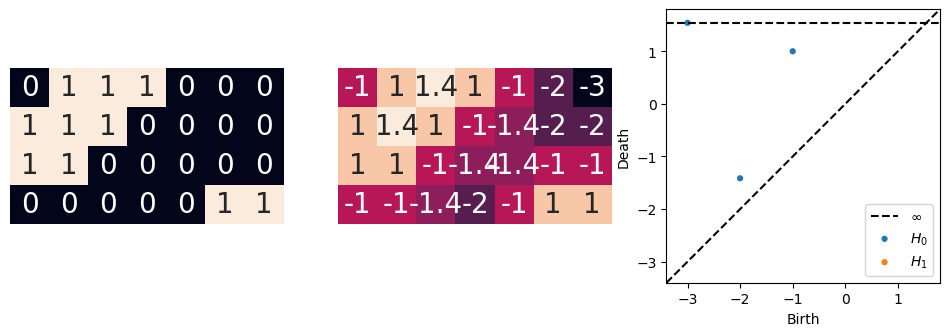

In [ ]:
## simple example with distance transform
# define a binary 2D array
simple_img=np.array([[0,1,1,1,0,0,0],
                      [1,1,1,0,0,0,0],
                      [1,1,0,0,0,0,0],
                      [0,0,0,0,0,1,1]],dtype=bool)

# apply distance transform
dt_img = dt(simple_img,signed=True)

# plot the array
fig,axs = plt.subplots(1,3,figsize=(12,4))
sns.heatmap(simple_img, annot=True, square=True, yticklabels=False, xticklabels=False, annot_kws={"fontsize":20}, cbar=False, ax=axs[0])
sns.heatmap(dt_img, annot=True, square=True, yticklabels=False, xticklabels=False, annot_kws={"fontsize":20}, cbar=False, ax=axs[1])

# compute PH of the 2D array (the V-construction)
pdt = cripser.computePH(dt_img)

# each line contains (dim,birth,death,x1,y1,z1,x2,y2,z2), where (x1,y1,z1) is the location of the creator cell of the cycle and (x2,y2,z2) is the location of the destroyer cell of the cycle"
print("[dim,birth,death,x1,y1,z1,x2,y2,z2]")
print(np.where(pdt<9, pdt, 9).astype(int)) # replace infty with 9 for printing

# plot persistence diagram
persim.plot_diagrams([p[:,1:3] for p in [pdt[pdt[:,0] == i] for i in range(2)]], ax=axs[2])
plt.show()

### grayscale photo

In [ ]:
# load a sample greyscale photo
img = skimage.data.camera()
## if you want to upload your own image to Google Colab
#from google.colab import files
#img = skimage.color.rgb2gray(io.imread(list(files.upload().keys())[0]))

# plot
plt.imshow(img, cmap='gray')
print(np.min(img),np.max(img),img.dtype)

0 255 uint8


In [ ]:
# compute PH of the sublevel filtration
# V-construction of the original image (pixel value filtration)
pd = cripser.computePH(img,maxdim=1)

# each line contains (dim,birth,death,x1,y1,z1,x2,y2,z2), where (x1,y1,z1) is the location of the creator cell of the cycle and (x2,y2,z2) is the location of the destroyer cell of the cycle"
print("[dim,birth,death,x1,y1,z1,x2,y2,z2]")
print(pd[:5])

# arrange degree-wise
pds = [pd[pd[:,0] == i] for i in range(2)]
print("Betti numbers: ",[len(pds[i]) for i in range(len(pds))])

# T-construction of the original image (pixel value filtration)
pdt = tcripser.computePH(img,maxdim=1)
pdst = [pdt[pdt[:,0] == i] for i in range(2)]
print("Betti numbers: ",[len(pdst[i]) for i in range(len(pdst))])

## plot persistent diagram using persim
fig,axs = plt.subplots(1,2)
persim.plot_diagrams([p[:,1:3] for p in pds], ax=axs[0], title='V-construction')
persim.plot_diagrams([p[:,1:3] for p in pdst], ax=axs[1], title='T-construction')


[dim,birth,death,x1,y1,z1,x2,y2,z2]
[[  0.   2.   3. 304. 157.   0. 305. 158.   0.]
 [  0.   2.   3. 306. 157.   0. 313. 154.   0.]
 [  0.   2.   3. 326. 152.   0. 327. 153.   0.]
 [  0.   2.   3. 322. 153.   0. 323. 153.   0.]
 [  0.   2.   3. 319. 153.   0. 320. 153.   0.]]
Betti numbers:  [22963, 13716]
Betti numbers:  [13563, 23286]


In [ ]:
## For greyscale images, we have another notion of persistence than the sublevel filtration
# the following function makes the input image binary and apply distance transform
# the sublevel filtration is suitable when pixel values have significant meaning in your data (like the HU value in CT)
# while the distance transform is suitable when you are interested in the scale of the geometric structure in your data.

from scipy.ndimage import distance_transform_edt
from skimage.filters import threshold_otsu
bw_img = (img >= threshold_otsu(img)) # binarise by Otsu's method
dt_img = dt(img,signed=True)
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(121)
ax.imshow(bw_img,cmap='gray')
ax = fig.add_subplot(122)
ax.imshow(dt_img, cmap='gray')

Betti numbers:  [717, 311]
Betti numbers:  [393, 725]


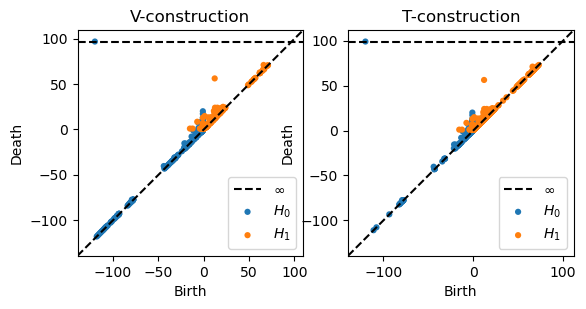

In [ ]:
# compute persistence of the distance transform
# V-construction of the distance transformed image
pd = cripser.computePH(dt_img)
pds = [pd[pd[:,0] == i] for i in range(2)]
print("Betti numbers: ",[len(pds[i]) for i in range(len(pds))])

# T-construction of the distance transformed image
pdt = tcripser.computePH(dt_img)
pdst = [pdt[pdt[:,0] == i] for i in range(2)]
print("Betti numbers: ",[len(pdst[i]) for i in range(len(pdst))])

## plot persistent diagram using persim
fig,axs = plt.subplots(1,2)
persim.plot_diagrams([p[:,1:3] for p in pds], ax=axs[0], title='V-construction')
persim.plot_diagrams([p[:,1:3] for p in pdst], ax=axs[1], title='T-construction')
plt.show()

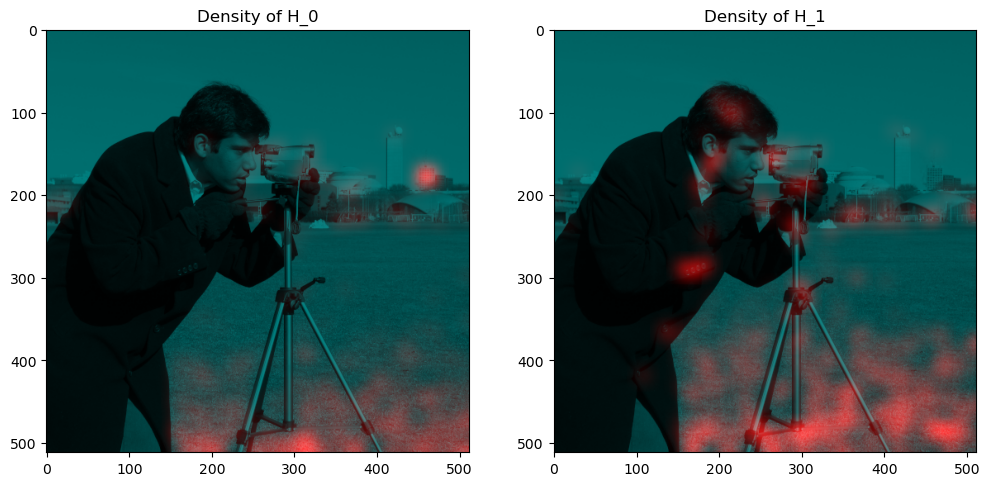

In [ ]:
## Plot heatmap for H_0 and H_1 showing the density of the birth locations of the cycles

pd = cripser.computePH(img, maxdim=1)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for i in range(2):
  heat = heat_map(img, pd, h=20, sigma=10, min_birth=10, min_life=30, dimension=i, location='birth')
  heat = (heat / np.max(heat) * 255).astype(np.uint8)
  axs[i].imshow(np.dstack([heat, img // 2, img // 2]))
  axs[i].set_title(f"Density of H_{i}")
plt.show()

### classification example

In [ ]:
## Power of PH as a feature extractor depends on the problem
## Let us perform a classification task with a synthetic dataset, where PH works well.

from skimage import data
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report

## create a binary classification problem consisting of random blobs of different size
n = 100
X = [data.binary_blobs(length=100, blob_size_fraction=0.1) for i in range(n)] # class A: small size
X.extend([data.binary_blobs(length=100, blob_size_fraction=0.12) for i in range(n)]) # class B: large size

# set class label
Y = [0 for i in range(n)]
Y.extend([1 for i in range(n)])

# split into train-test datasets
(train_idx, test_idx, trainY, testY) = train_test_split(range(len(X)), Y, test_size = 0.3, random_state = 0, stratify=Y)

# plot
fig,axs = plt.subplots(2,10,figsize=(20,4))
for i in range(10):
  axs[0,i].imshow(X[i])
  axs[1,i].imshow(X[i+n])
  axs[0,i].axis('off')
  axs[1,i].axis('off')


In [ ]:
## classification using pixel values themselves
# the result is not good because the pixel values are not discriminative

trainX=[X[i].ravel() for i in train_idx]
testX=[X[i].ravel() for i in test_idx]
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(trainX, trainY)
predY = clf.predict(testX)
print("Confusion matrix\n",confusion_matrix(testY,predY))
print(classification_report(testY,predY))


Confusion matrix
 [[16 14]
 [11 19]]
              precision    recall  f1-score   support

           0       0.59      0.53      0.56        30
           1       0.58      0.63      0.60        30

    accuracy                           0.58        60
   macro avg       0.58      0.58      0.58        60
weighted avg       0.58      0.58      0.58        60



In [ ]:
# since the size matters in this task, we apply distance transform to extract size information in PH

pds = []
for i in range(len(X)):
    pd = cripser.computePH(dt(X[i],signed=True))    # compute PH of distance transform
    pds.append(pd)

# plot some of them
fig,axs = plt.subplots(4,10,figsize=(20,8))
for i in range(10):
  axs[0,i].imshow(dt(X[i],signed=True))
  axs[0,i].axis('off')
  pd=pds[i]
  persim.plot_diagrams([p[:,1:3] for p in [pd[pd[:,0] == i] for i in range(2)]],ax = axs[1,i], legend=False)
  axs[2,i].imshow(dt(X[i+n],signed=True))
  axs[2,i].axis('off')
  pd=pds[i+n]
  persim.plot_diagrams([p[:,1:3] for p in [pd[pd[:,0] == i] for i in range(2)]],ax = axs[3,i], legend=False)

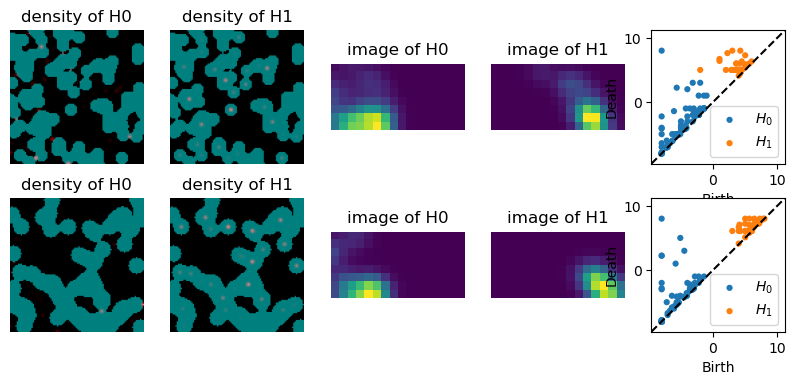

In [ ]:
# plot some of the data
# CAUTION: with the "PersistenceImages" library, xy are transposed; i.e., axis0: lifetime, axis1: birth
# This is different from the persim library, but it is faster.

import PersistenceImages.persistence_images as pimg
max_life = 8
pixel_size = 1
pim = pimg.PersistenceImager(birth_range=(-max_life,max_life), pers_range=(0,max_life), pixel_size=pixel_size)

idx = [0,n]
nn=len(idx)
fig,axs = plt.subplots(nn,5,figsize=(nn*5,4))
for i in range(nn):
  img = X[idx[i]]*255
  pd = pds[idx[i]]
  for d in range(2):
    heat=heat_map(img,pd,h=5,sigma=1,min_life=0,max_life=max_life,min_birth =-max_life,max_birth = max_life,dimension=d,location='death')
    heat = (heat/max(1,np.max(heat))*255).astype(np.uint8)
    axs[i,0+d].imshow(np.dstack([heat,img//2,img//2]))
    axs[i,0+d].set_title("density of H{}".format(d))
    axs[i,0+d].axis('off')
    axs[i,2+d].imshow(pim.transform(pd[pd[:,0]==d,1:3], skew=True).T, origin="lower")
    axs[i,2+d].set_title("image of H{}".format(d))
    axs[i,2+d].axis('off')
  persim.plot_diagrams([p[:,1:3] for p in [pd[pd[:,0] == i] for i in range(2)]],ax = axs[i,4])
plt.show()

In [ ]:
### Feature extraction through persistence image
# the resulting persistence image is used as a feature for classification

dim = 1 # which PH dim to look at?
pims_h = []
for i in range(len(X)):
    pd = pds[i]
    pd[:,1:3] = np.clip(pd[:,1:3],a_min=-max_life,a_max=max_life) # clip min/max birth/death
    pim0 = pim.transform(pd[pd[:,0]==dim,1:3],skew=True) # vectorise PH by persistence image
    pims_h.append(pim0.ravel())

## classification
trainX=[pims_h[i] for i in train_idx]
testX=[pims_h[i] for i in test_idx]
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(trainX, trainY)
predY = clf.predict(testX)
print("Confusion matrix\n",confusion_matrix(testY,predY))
print(classification_report(testY,predY))


Confusion matrix
 [[30  0]
 [ 0 30]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00        30

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



Important feature: birth around  2.666666666666666 lifetime around  0.0


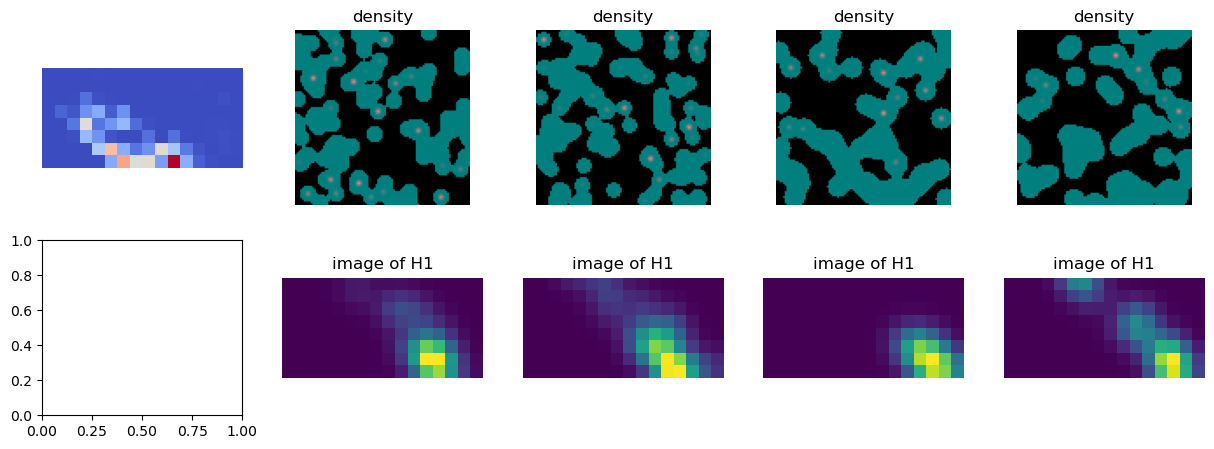

In [ ]:
## identify what variables have impact on the decision
# in this case, the region of the persistence image of H1
# this kind of visualisation is useful for explaining results and seek for a mechanism behind the phenomena at hand.
indices = np.argsort(clf.feature_importances_)
#plt.barh(range(len(indices)), clf.feature_importances_[indices])

idx = [0,1,n,n+1]
nn = len(idx)

fig,axs = plt.subplots(2,nn+1,figsize=(3+nn*3,5))
axs[0,0].imshow(clf.feature_importances_.reshape(pim0.shape).T,origin="lower",cmap='coolwarm')
axs[0,0].axis('off')
most_important = np.unravel_index(indices[-1], shape=pim0.shape)
life,birth = np.meshgrid(np.linspace(0,max_life,pim0.shape[1]),np.linspace(-max_life,max_life,pim0.shape[0]))
b = birth[most_important]
l = life[most_important]
print("Important feature: birth around ", b,"lifetime around ", l)

# annotate the density of the most contributing feature on the image
# For demonstration, we pick some images from each class.
# the annotation explains how the classifier discerns two classes
for i in range(nn):
  img = X[idx[i]]*255
  pd = pds[idx[i]]
  h = 3*pixel_size
  heat=heat_map(img,pd,h=5,sigma=1,min_life=l-h,max_life=l+h,min_birth =b-h,max_birth = b+h,dimension=dim,location='death')
  heat = (heat/max(1,np.max(heat))*255).astype(np.uint8)
  axs[0,i+1].imshow(np.dstack([heat,img//2,img//2]))
  axs[0,i+1].set_title("density")
  axs[0,i+1].axis('off')
  axs[1,i+1].imshow(pim.transform(pd[pd[:,0]==dim,1:3],skew=True).T,origin="lower")
  axs[1,i+1].set_title("image of H{}".format(dim))
  axs[1,i+1].axis('off')

plt.show()

## Volume

(256, 256, 12) float64 0.00434882124055848--0.9204089417868314


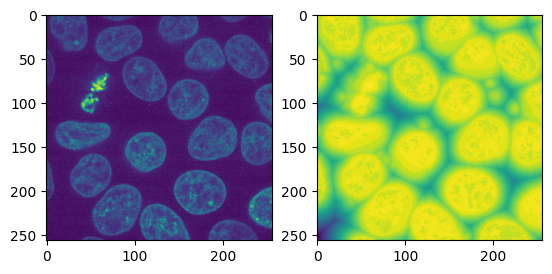

In [ ]:
## set the following appropriately
IMG_DIR = "./images/"  ## dir containing images for a 3D example; all the images must be of the same dimension

# create a 3d stack from 2d images
if os.path.isdir(IMG_DIR):
    from PIL import Image
    # load image files from a dir and stack into a 3D array of type float64
    input_files = os.path.join(IMG_DIR,"*.jpg")
    files = [f for f in glob.glob(input_files)]
    files.sort(key=lambda val : int(re.sub("\\D", "", val+"0")))
    img3d = np.dstack([Image.open(f).convert('L') for f in files]).astype('f8')
else:
    from skimage.data import cells3d
    img3d = skimage.util.img_as_float(cells3d()[::5, 1, :, :]).transpose((1,2,0))  # requires pooch
    #from skimage.transform import rotate
    #img3d = np.dstack([rotate(img, 10*i) for i in range(8)])

## apply distance transform
img3d_dt = dt(img3d,signed=True)

fig,axs = plt.subplots(1,2)
axs[0].imshow(img3d[:,:,img3d.shape[-1]//2])
axs[1].imshow(img3d_dt[:,:,img3d_dt.shape[-1]//2])
print(img3d.shape, img3d.dtype, f"{np.min(img3d)}--{np.max(img3d)}")


In [ ]:
# 3D plot of slices
explore_slices(img3d)

interactive(children=(IntSlider(value=6, description='plane', max=11), Output()), _dom_classes=('widget-intera…

<function __main__.explore_slices.<locals>.display_slice(plane=6)>

Betti numbers:  [82327, 84832, 15407]
Betti numbers:  [21927, 85320, 56847]


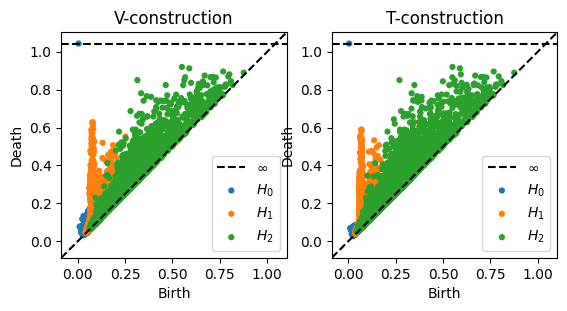

In [ ]:
# sublevel filtration of the original image (pixel value filtration)
# V-construction
pd = cripser.computePH(img3d)
pds = [pd[pd[:,0] == i] for i in range(3)]
print("Betti numbers: ",[len(pds[i]) for i in range(len(pds))])

# T-construction of the original image (pixel value filtration)
pdt = tcripser.computePH(img3d)
pdst = [pdt[pdt[:,0] == i] for i in range(3)]
print("Betti numbers: ",[len(pdst[i]) for i in range(len(pdst))])

## plot persistent diagram using persim
fig,axs = plt.subplots(1,2)
persim.plot_diagrams([p[:,1:3] for p in pds], ax=axs[0], title='V-construction')
persim.plot_diagrams([p[:,1:3] for p in pdst], ax=axs[1], title='T-construction')
plt.show()

In [ ]:
%%timeit -r 3
# compute PH for the T-construction by GUDHI
gd = gudhi.CubicalComplex(top_dimensional_cells=img3d)
#gd = gudhi.CubicalComplex(vertices=img)
#    gd.compute_persistence()
res = gd.persistence(2,0) # coeff = 2
print("Betti numbers: ", gd.persistent_betti_numbers(np.inf,-np.inf))


Betti numbers:  [25798, 97689, 64399, 0]
Betti numbers:  [25798, 97689, 64399, 0]
Betti numbers:  [25798, 97689, 64399, 0]
Betti numbers:  [25798, 97689, 64399, 0]
5.78 s ± 17 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [ ]:
%%timeit -r 3
# compute PH for the T-construction by CubicalRipser, which is faster
pdt = tcripser.computePH(img3d, fortran_order=True)
pdst = [pdt[pdt[:,0] == i] for i in range(3)]
print("Betti numbers: ",[len(pdst[i]) for i in range(len(pdst))])


Betti numbers:  [25798, 97689, 64399]
Betti numbers:  [25798, 97689, 64399]
Betti numbers:  [25798, 97689, 64399]
Betti numbers:  [25798, 97689, 64399]
2.38 s ± 27.3 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


## Time series

Time series is a 1D image, so the techniques in the previous section apply straightforwardly. Here, we see examples with different tasks.

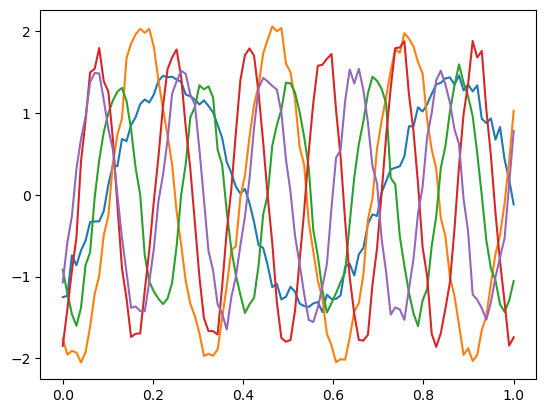

In [ ]:
# synthetic example:
# Goal: to infer the period of sine curve from noisy data

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score

# create a sine curve with noise
n=200  # number of samples
t = np.linspace(0,1,100)
a=np.random.uniform(low=1,high=2,size=n)  # amplitude
b=np.random.uniform(low=1.5,high=7,size=n) # period <= our target for regression
c=np.random.uniform(low=-np.pi,high=np.pi,size=n) # phase
# create different sine curves with noise
X = [a[i]*np.sin(2*np.pi*b[i]*t+c[i]) + np.random.normal(scale=0.1,size=len(t)) for i in range(n)]
for i in range(5):
    plt.plot(t,X[i])
plt.show()

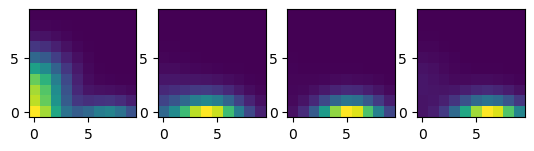

In [ ]:
## compute PH and vectorise by persistence image
import persim,cripser
import PersistenceImages.persistence_images as pimg

#pim=persim.PersImage(pixels=[10,10], spread=1) ## for persim
pim = pimg.PersistenceImager(birth_range=(0,5), pers_range=(0,5), pixel_size=0.5)
#print(pim)
pds, pims = [], []
for i in range(len(X)):
    pd = cripser.computePH(X[i])[:,1:3]    # compute PH
    pds.append(np.clip(pd,a_min=-2,a_max=2))  # clip min/max birth/death
    pims.append(pim.transform(pds[i])) # vectorise by persistence image
for i in range(4):   # plot persistence images for the first four samples
    ax = plt.subplot(240+i+1)
    ax.imshow(pims[i],origin='lower')
    #pim.show(pims[i], ax) ## for persim
plt.show()

MSE train : 0.141, test : 0.215
R2 train : 0.948, test : 0.923


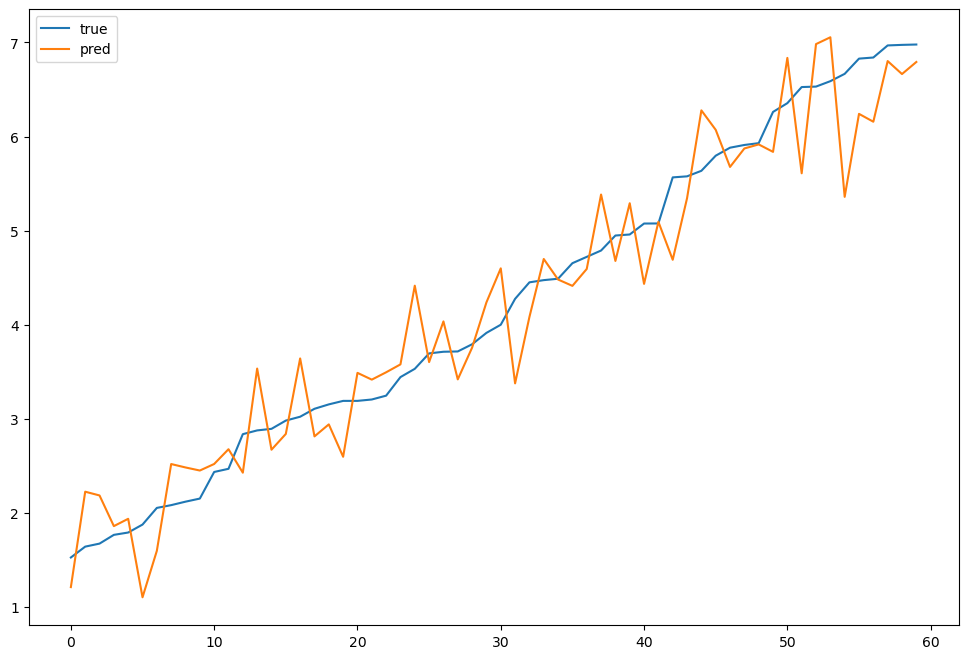

In [ ]:
# linear regression for the period: Input: PH of time series => Output: period
# train-test split
(trainX, testX, trainY, testY) = train_test_split(np.array(pims).reshape(n,-1), b, test_size = 0.3, random_state = 0) # use PH features

# fit model
clf = linear_model.Lasso(alpha=0.0001,max_iter=10000)
clf.fit(trainX, trainY)

# prediction: the result is reasonably good
trainPred = clf.predict(trainX)
testPred = clf.predict(testX)
print('MSE train : %.3f, test : %.3f' % (mean_squared_error(trainY,trainPred), mean_squared_error(testY,testPred)) )
print('R2 train : %.3f, test : %.3f' % (r2_score(trainY,trainPred), r2_score(testY,testPred)) )

# sort the test data for visualisation
idx = np.argsort(testY)
testY=testY[idx]
testPred=testPred[idx]

plt.figure(figsize=(12,8))
plt.plot(testY,label="true")
plt.plot(testPred, label="pred")
plt.legend()
plt.show()

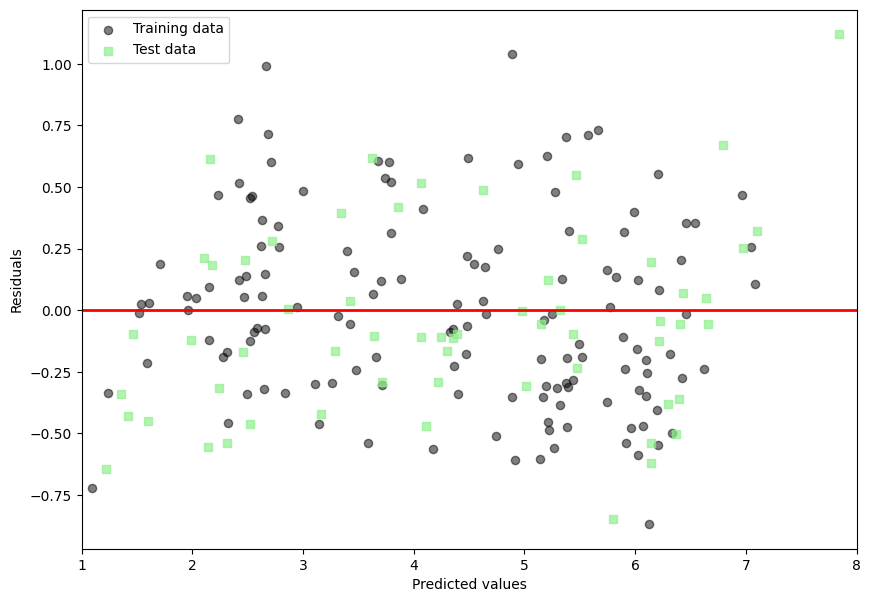

In [ ]:
# residual plot
plt.figure(figsize = (10, 7))
plt.scatter(trainPred, trainPred - trainY, c = 'black', marker = 'o', s = 35, alpha = 0.5, label = 'Training data')
plt.scatter(testPred, testPred - testY, c = 'lightgreen', marker = 's', s = 35, alpha = 0.7, label = 'Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc = 'upper left')
plt.hlines(y = 0, xmin = 1, xmax = 8, lw = 2, color = 'red')
plt.xlim([1, 8])
plt.show()

MSE train : 0.682, test : 7.195
R2 train : 0.750, test : -1.590


c:\Users\user\miniforge3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.146e+00, tolerance: 3.824e-02
  model = cd_fast.enet_coordinate_descent(


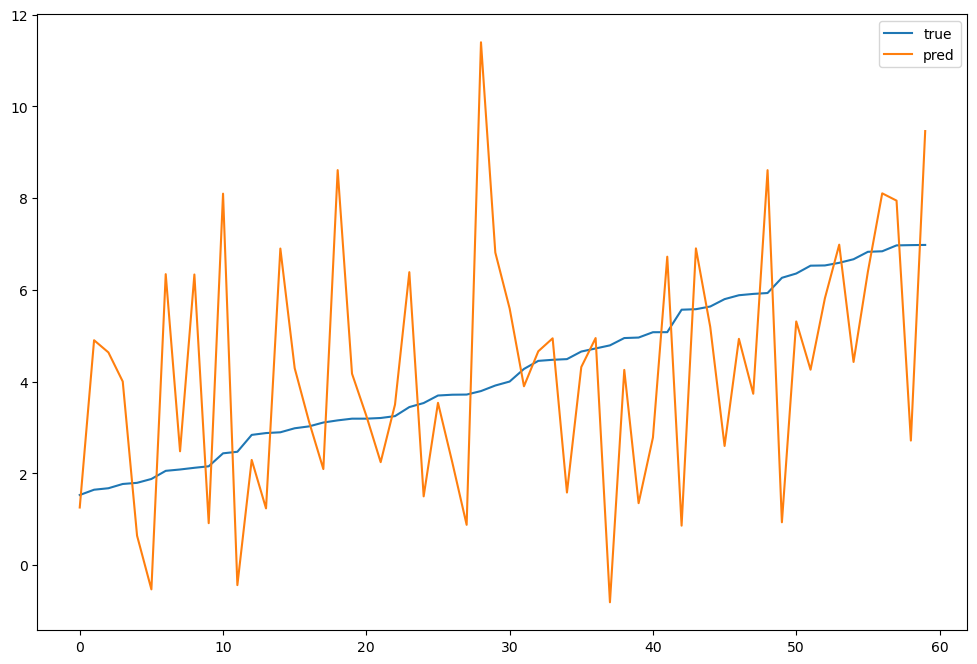

In [ ]:
## If we use the original data directly instead of PH, the result is worse
# Input: original time series => Output: period

X_flat = np.array(X).reshape(n, -1)

(trainX, testX, trainY, testY) = train_test_split(X, b, test_size = 0.3, random_state = 0)  # see what happens if we use the input data directly

# fit model
clf = linear_model.Lasso(alpha=0.0001,max_iter=10000)
clf.fit(trainX, trainY)

# prediction: the result is much worse!
trainPred = clf.predict(trainX)
testPred = clf.predict(testX)
print('MSE train : %.3f, test : %.3f' % (mean_squared_error(trainY,trainPred), mean_squared_error(testY,testPred)) )
print('R2 train : %.3f, test : %.3f' % (r2_score(trainY,trainPred), r2_score(testY,testPred)) )

# sort the test data for visualisation
idx = np.argsort(testY)
testY=testY[idx]
testPred=testPred[idx]

plt.figure(figsize=(12,8))
plt.plot(testY,label="true")
plt.plot(testPred, label="pred")
plt.legend()
plt.show()

MSE train : 0.417, test : 0.463
R2 train : 0.847, test : 0.833


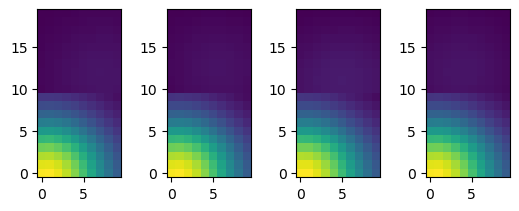

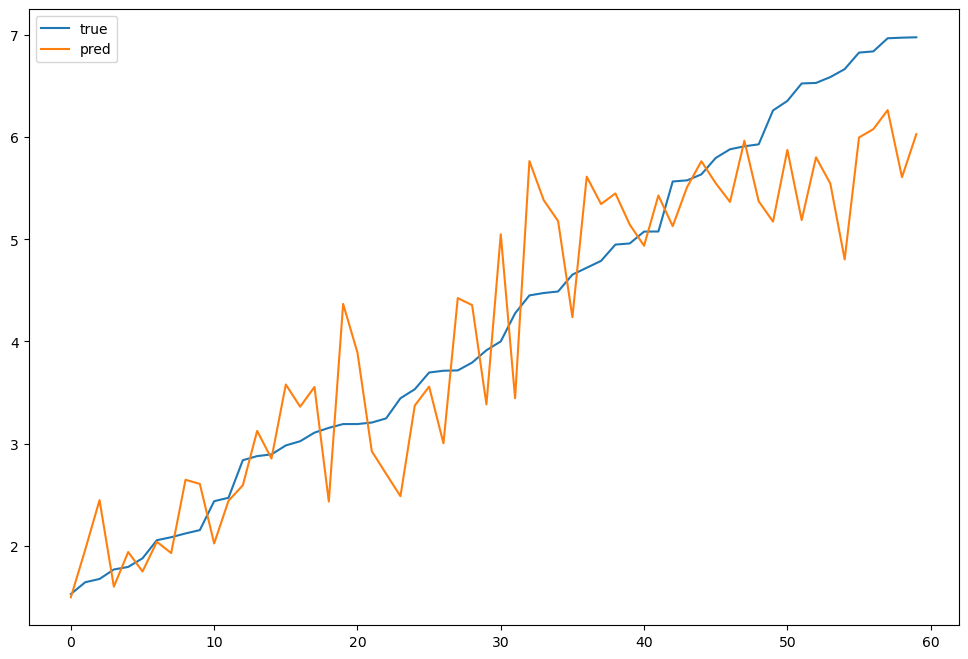

In [ ]:
# Instead of directly computing PH of the time series as a function over the real line,
# we can use Takens' embedding to first convert the time series into a geometric object (approximated attractor)
# and look at its topological features by PH. The result is not so good in this particular case.
# Input: Takens' embedded time series => Output: period

import gudhi.point_cloud.timedelay
embedder = gudhi.point_cloud.timedelay.TimeDelayEmbedding(dim=2, delay=3, skip=1)
X_takens = embedder.transform(X)

pim = pimg.PersistenceImager(birth_range=(0,2), pers_range=(0,2), pixel_size=0.2)
pds, pims = [], []
for i in range(len(X)):
    pd = ripser(X_takens[i])['dgms']    # compute PH
    pim0 = pim.transform(np.clip(pd[0],a_min=0,a_max=2)) #PH_0
    pim1 = pim.transform(np.clip(pd[1],a_min=0,a_max=2)) #PH_1
    pims.append(np.concatenate([pim0,pim1])) # combine PH_0 and PH_1 to make a feature vector
for i in range(4):   # plot persistence images
    ax = plt.subplot(240+i+1)
    ax.imshow(pims[i],origin='lower')
    #pim.show(pims[i], ax) ## for persim

## linear regression fot the period
# train-test split
(trainX, testX, trainY, testY) = train_test_split(np.array(pims).reshape(n,-1), b, test_size = 0.3, random_state = 0) # use PH features

# fit model
clf = linear_model.Lasso(alpha=0.0001,max_iter=10000)
clf.fit(trainX, trainY)

# prediction: the result is worse than without embedding.
# This is reasonable; because with the direct signal, 0-th betti number corresponds to the frequency.
# Takens' embedding is useful when dealing with signals coming from deterministic dynamical systems,
# as the embedding reconstructs the attractors of the systems.

trainPred = clf.predict(trainX)
testPred = clf.predict(testX)
print('MSE train : %.3f, test : %.3f' % (mean_squared_error(trainY,trainPred), mean_squared_error(testY,testPred)) )
print('R2 train : %.3f, test : %.3f' % (r2_score(trainY,trainPred), r2_score(testY,testPred)) )

# sort the test data for visualisation
idx = np.argsort(testY)
testY=testY[idx]
testPred=testPred[idx]

plt.figure(figsize=(12,8))
plt.plot(testY,label="true")
plt.plot(testPred, label="pred")
plt.legend()
plt.show()

In [ ]:
## non-linear feature selection with RandomForest (this takes a little time)
## Locate which entries in Persistence Image have a large impact in the prediction.
## This tells cycles in what range of birth and life are important for the current task at hand.

from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy # obsolete
#from eBoruta import eBoruta

(trainX, testX, trainY, testY) = train_test_split(np.array(pims).reshape(n,-1), b, test_size = 0.3, random_state = 0) # use PH features

# feature selection with Boruta: takes a few minutes
rf = RandomForestRegressor(n_jobs=-1,n_estimators=50,max_depth=15)
feat_selector = BorutaPy(rf, verbose=0)
#feat_selector = eBoruta()
feat_selector.fit(trainX, trainY)
#print(feat_selector.ranking_)

X_filtered = feat_selector.transform(trainX)
rf.fit(X_filtered, trainY)
trainPred = rf.predict(X_filtered)
testPred = rf.predict(feat_selector.transform(testX))
print('MSE train : %.3f, test : %.3f' % (mean_squared_error(trainY,trainPred), mean_squared_error(testY,testPred)) )
print('R2 train : %.3f, test : %.3f' % (r2_score(trainY,trainPred), r2_score(testY,testPred)) )

# plot selected region in persistent image
plt.imshow(feat_selector.support_.reshape(pims[0].shape),origin='lower')
plt.show()

AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 66689 (260.50 KB)
Trainable params: 66689 (260.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
7/7 [==============================] - 4s 269ms/step - loss: 20.8134 - val_loss: 15.4678
Epoch 2/100
7/7 [==============================] - 1s 182ms/step - loss: 9.6606 - val_loss: 5.2172
Epoch 3/100
7/7 [==============================] - 1s 186ms/step - loss: 4.0735 - 

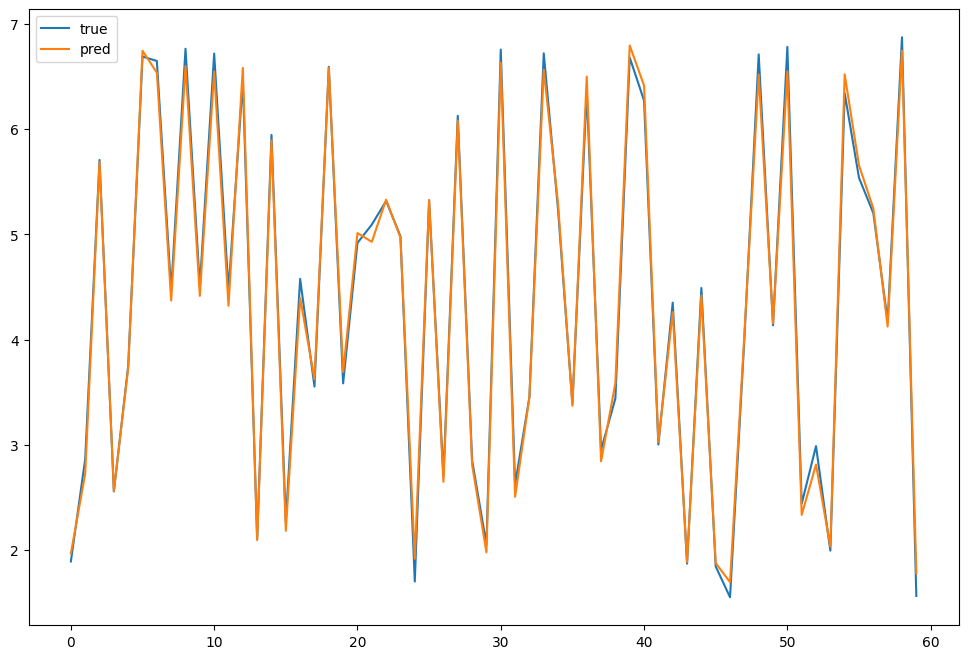

In [ ]:
## Let's compare the performance with LSTM (a popular version of recurrent neural network)
from keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, LSTM
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# train-test split
(trainX, testX, trainY, testY) = train_test_split(np.array(X).reshape(n,-1,1), b, test_size = 0.3, random_state = 0)

# LSTM model definition
num_hidden_units = 128
model = Sequential()
model.add(LSTM(
    num_hidden_units,
    input_shape=(len(t), 1),
    return_sequences=False))
model.add(Dense(1))
model.add(Activation("linear"))
model.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=0.001))
model.summary()

# train
model.fit(trainX, trainY, batch_size=20, epochs=100,
    validation_split=0.1,   ## isn't it unfair?
    callbacks=[EarlyStopping(monitor='val_loss', mode='auto', patience=50)]
)

# prediction: LSTM performs better
trainPred = model.predict(trainX)
testPred = model.predict(testX)
print('MSE train : %.3f, test : %.3f' % (mean_squared_error(trainY,trainPred), mean_squared_error(testY,testPred)) )
print('R2 train : %.3f, test : %.3f' % (r2_score(trainY,trainPred), r2_score(testY,testPred)) )
plt.figure(figsize=(12,8))
plt.plot(testY,label="true")
plt.plot(testPred, label="pred")
plt.legend()
plt.show()

# Dimension reduction
Dimension reduction techniques can be used for:
- Visualisation
- Preprocessing for regressor/classifier
- Outlier detection

(901, 64)


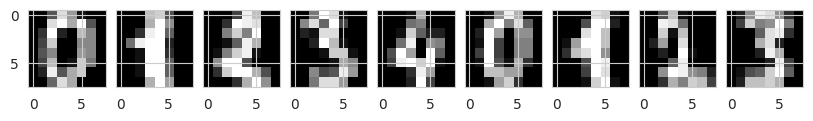

In [ ]:
# load demo data: hand written digits
import sklearn
import sklearn.datasets
from scipy import stats
from sklearn import manifold
from sklearn.decomposition import PCA
from mpl_toolkits.axes_grid1 import ImageGrid
# seaborn makes matplot drawing charming
import seaborn as sns
sns.set_style("whitegrid")

X,Y = sklearn.datasets.load_digits(n_class=5,return_X_y=True)
print(X.shape)
num_disp=9
fig = plt.figure(figsize=(10, 2))
grid = ImageGrid(fig, 111,nrows_ncols=(1, num_disp),axes_pad=0.1)
for ax,x in zip(grid, X[:num_disp]):
    ax.imshow(x.reshape(8,8),cmap="gray")


### Visualisation

### PCA

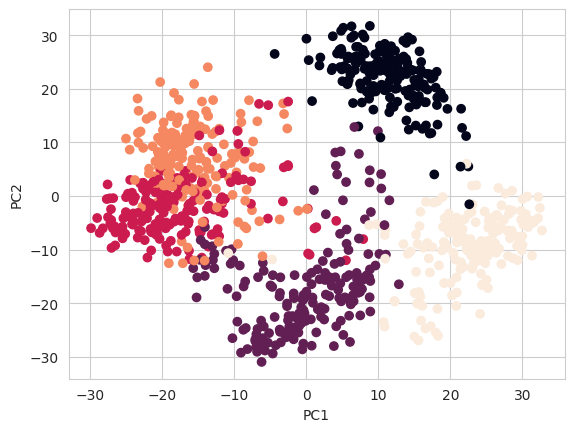

In [ ]:
## everyone's favourite PCA: indeed, it is not so bad though there are some overlaps among different classes (indicated by the point colour)
pca = PCA(n_components=3)
X_pca = pca.fit(X).transform(X)
# plot first and second primary components
plt.scatter(X_pca[:,0],X_pca[:,1],c=Y)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

### t-SNE

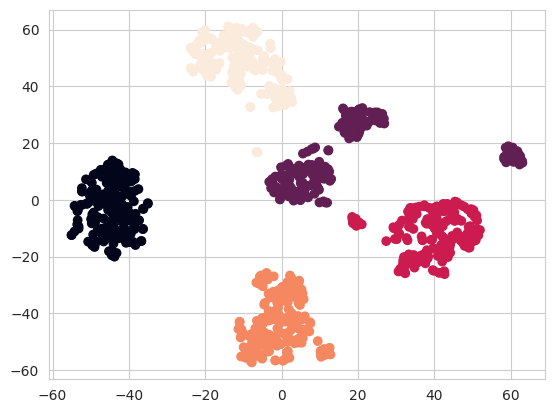

In [ ]:
# t-SNE: one of the most popular method. Excellent for preprocess but the meaning of the components are less clear
X_tsne = manifold.TSNE(n_components=2,perplexity=20).fit_transform(X)
plt.scatter(X_tsne[:,0],X_tsne[:,1],c=Y)


### umap

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


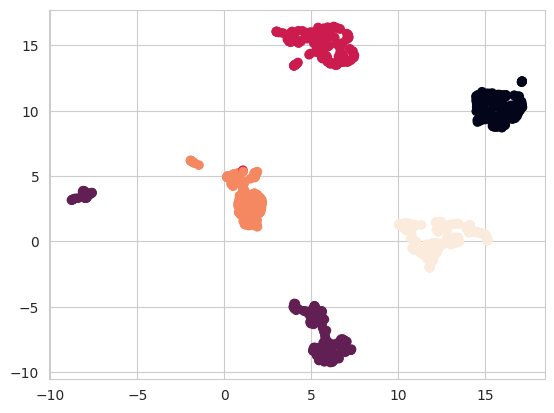

In [ ]:
# Universal Manifold Learning (umap): projects vectors while keeping the topology
import umap
X_umap = umap.UMAP(n_components=2, n_neighbors=5, metric='euclidean').fit_transform(X)
plt.scatter(X_umap[:,0],X_umap[:,1],c=Y)

### Mapper

In [ ]:
## Mapper: good for revealing rich topology but difficult to tune
# the visualisation does not work with Google Colab. Please use Jupyter-notebook
import kmapper, kmapper.jupyter
from sklearn.preprocessing import StandardScaler
import networkx as nx

km = kmapper.KeplerMapper()
X_std = StandardScaler().fit_transform(X)   # standardise
f = km.project(X_std,projection="sum") # we have to choose a 1-dim projection
graph = km.map(lens=f, X=X_std, clusterer=sklearn.cluster.DBSCAN(metric="cosine",algorithm='auto', eps=0.3, leaf_size=10))
nx.draw(kmapper.adapter.to_nx(graph))
#km.visualize(graph, color_function=Y, custom_tooltips=Y, path_html="kepler-mapper-output.html") # To download the output, look at the beginning of this note
km.visualize(graph, custom_tooltips=Y, path_html="kepler-mapper-output.html") # To download the output, look at the beginning of this note
print("Download kepler-mapper-output.html and open it with a browser to see the results.")
# the following rich visualisation does not work with Google Colab.
# download "kepler-mapper-output.html" and open it locally with a browser
#kmapper.jupyter.display(path_html="kepler-mapper-output.html")

## Preprocess for Classification

In [ ]:
## classification with Randomforest
# first, directly with the vector data (image pixel values)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# train-test split
(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.3, random_state = 0)

clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(trainX, trainY)
predY = clf.predict(testX)

# classification results
from sklearn.metrics import roc_curve,roc_auc_score,confusion_matrix,classification_report
print("Confusion matrix\n",confusion_matrix(testY,predY))
print(classification_report(testY,predY))

Confusion matrix
 [[52  0  0  0  0]
 [ 0 51  2  5  3]
 [ 0  2 54  3  0]
 [ 0  1  3 47  1]
 [ 1  0  0  0 46]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        52
           1       0.94      0.84      0.89        61
           2       0.92      0.92      0.92        59
           3       0.85      0.90      0.88        52
           4       0.92      0.98      0.95        47

    accuracy                           0.92       271
   macro avg       0.92      0.93      0.92       271
weighted avg       0.92      0.92      0.92       271



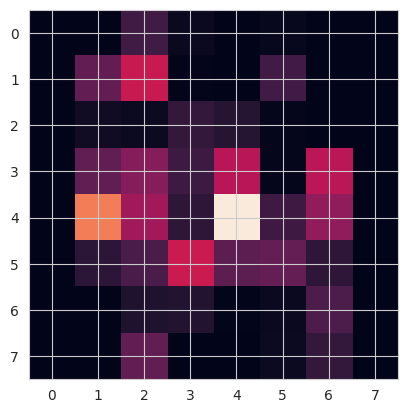

In [ ]:
## identify what variables have impact on the decision
# in this case, which pixels are important to distinguish digits
indices = np.argsort(clf.feature_importances_)
#plt.barh(range(len(indices)), clf.feature_importances_[indices])
plt.imshow(clf.feature_importances_.reshape(8,8))

In [ ]:
## Now, first dimension reduction (64 -> 5) and classify
# You'll observe the accuracy gets better!
X_umap = umap.UMAP(n_components=5, n_neighbors=5, metric='euclidean').fit_transform(X)
(trainX, testX, trainY, testY) = train_test_split(X_umap, Y, test_size = 0.3, random_state = 0)
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(trainX, trainY)
predY = clf.predict(testX)
print("Confusion matrix\n",confusion_matrix(testY,predY))
print(classification_report(testY,predY))

Confusion matrix
 [[52  0  0  0  0]
 [ 0 61  0  0  0]
 [ 0  0 59  0  0]
 [ 0  0  0 52  0]
 [ 0  0  0  0 47]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        52
           1       1.00      1.00      1.00        61
           2       1.00      1.00      1.00        59
           3       1.00      1.00      1.00        52
           4       1.00      1.00      1.00        47

    accuracy                           1.00       271
   macro avg       1.00      1.00      1.00       271
weighted avg       1.00      1.00      1.00       271



In [ ]:
## for comparison, use persistence image as a feature extractor and do classification
# We see it is insufficient to look at PH in this case; only digit 0 can be classified with a reasonable accuracy
# It is VERY important to understand that TDA does not replace conventional methods.
# In fact, TDA is usually much weaker when used alone. Therefore, TDA should be used as a complementary analysis technique.
pim = pimg.PersistenceImager(birth_range=(0,3), pers_range=(0,3), pixel_size=0.5)
pds, pims_h0, pims_h1 = [], [], []
for i in range(len(X)):
    img = X[i].reshape(8,8)
    bw_img = (img >= threshold_otsu(img))
    dt_img = distance_transform_edt(~bw_img)
    pd = cripser.computePH(dt_img)    # compute PH of distance transform
    pd[:,1:3] = np.clip(pd[:,1:3],a_min=0,a_max=3) # clip min/max birth/death
    pds.append(pd)
    pim0 = pim.transform(pd[pd[:,0]==0,1:3])
    pim1 = pim.transform(pd[pd[:,0]==1,1:3])
    pims_h0.append(pim0.ravel()) # vectorise by persistence image
    pims_h1.append(pim1.ravel()) # vectorise by persistence image

(trainX, testX, trainY, testY) = train_test_split(pims_h1, Y, test_size = 0.3, random_state = 0)
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(trainX, trainY)
predY = clf.predict(testX)
print("Confusion matrix\n",confusion_matrix(testY,predY))
print(classification_report(testY,predY))


Confusion matrix
 [[43  0  0  9  0]
 [ 0  0  0 61  0]
 [ 0  0  0 59  0]
 [ 1  0  0 51  0]
 [ 5  0  0 42  0]]
              precision    recall  f1-score   support

           0       0.88      0.83      0.85        52
           1       0.00      0.00      0.00        61
           2       0.00      0.00      0.00        59
           3       0.23      0.98      0.37        52
           4       0.00      0.00      0.00        47

    accuracy                           0.35       271
   macro avg       0.22      0.36      0.24       271
weighted avg       0.21      0.35      0.23       271



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##Clustering

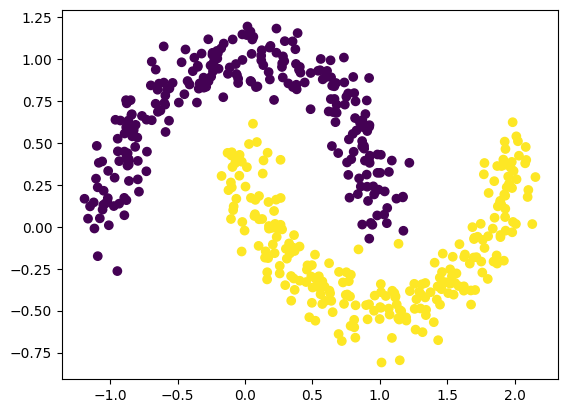

In [ ]:
## ToMATo (Topological Mode Analysis Tool)
# an interesting and less-known application of persistent homology is to clustering.
# input: graph with real values on vertices => clustering for vertices
import tomaster
import sklearn.datasets
X,_ = sklearn.datasets.make_moons(n_samples=500, noise=0.1)
clusters = tomaster.tomato(points = X, k=10, n_clusters=2)
plt.scatter(*X.T, c=clusters)
# Compare the results in https://scikit-learn.org/stable/modules/clustering.html

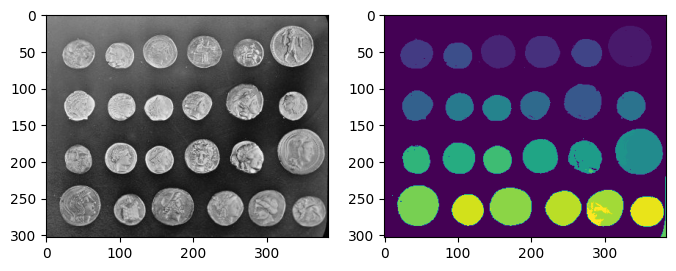

In [ ]:
## ToMaTo applied for image segmentation
# just for demonstration: there are better ways for ordinary segmentation tasks.
import skimage
img = skimage.data.coins()
clusters = tomaster.tomato_img(img, spatial_weight=1, k=10, n_clusters=30)
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(121)
ax.imshow(img,cmap='gray')
ax = fig.add_subplot(122)
ax.imshow(clusters)


# Coordination with PyTorch

## system preparation

In [ ]:
!pip install -q torch_topological

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 554.6/554.6 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 671.1/671.1 kB 30.6 MB/s eta 0:00:00


## function definition

In [ ]:
from tqdm.auto import tqdm
import torch
import torch.optim as optim
from torch_topological.nn import SummaryStatisticLoss
from torch_topological.nn import CubicalComplex,WassersteinDistance
from torch_topological.nn import WassersteinDistance,AlphaComplex,VietorisRipsComplex,SummaryStatisticLoss,PersistenceInformation
from torch_topological.data import sample_from_sphere,sample_from_disk,sample_from_unit_cube
from torch_topological.utils import SelectByDimension
from IPython.display import clear_output, display, update_display

# parameters
eps = 1e-8

# Device configuration
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu' # cpu seems to be faster in most cases

print('Device', device)

Device cpu


## Image optimisation

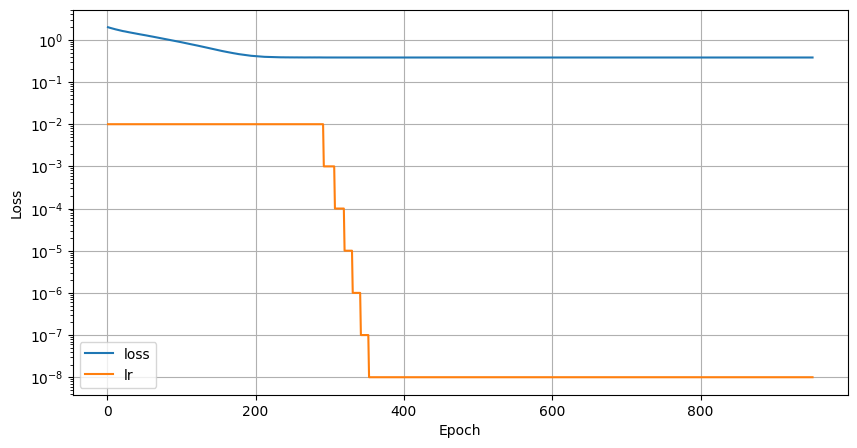

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
# Parameters
n_iterations = 1000
statistic = "polynomial_function"

# Initialize Cubical Complex and loss function
cpx = CubicalComplex(dim=2)
loss_fn = WassersteinDistance(q=2)

# Generate synthetic image
n, m = 30, 30
y, x = np.mgrid[-6:6:n*1j, -3:3:m*1j]
noise = 0.0

Y = np.cos(x) - np.sin(y) + 0.1*y
X = np.cos(2*x) - np.sin(2*y) + 0.1*x
X = X + np.random.normal(scale=noise, size=X.shape)
X_org = X.copy()

# Convert to tensors
Y = torch.as_tensor(Y, dtype=torch.float, device=device)
X = torch.as_tensor(X, dtype=torch.float, device=device)

# Set X as a parameter to optimise
X = torch.nn.Parameter(X, requires_grad=True).to(device)

# Compute target persistence
pi_target = cpx(Y)

# Optimizer and scheduler
optimizer = torch.optim.Adam([X], lr=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

# Initialize loss tracking
losses = {"epoch":[], "loss": [], "lr":[]}
fig, ax = plt.subplots(figsize=(10, 5))
loss_line, = ax.plot([], [], label='loss')
lr_line, = ax.plot([], [], label='lr')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_yscale('log')
ax.legend()
ax.grid(True)
loss_display = display(fig, display_id=True)

# Optimisation loop
progress = tqdm(range(n_iterations))
for i in progress:
    # Forward pass
    pi_source = cpx(X)
    loss = loss_fn(pi_source[0], pi_target[0])
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step(loss)
    # Track losses
    losses["loss"].append(loss.item())
    losses["epoch"].append(i+1)
    losses["lr"].append(scheduler.get_last_lr()[0])

    progress.set_postfix(loss=f'{loss.item():.08f}')
    # Plot losses dynamically every 50 iterations
    if i % 50 == 0:
        loss_line.set_data(losses["epoch"], losses["loss"])
        lr_line.set_data(losses["epoch"], losses["lr"])
        ax.relim()
        ax.autoscale_view()
        update_display(fig, display_id=loss_display.display_id)

# Get results
X = X.detach().cpu().numpy()
Y = Y.detach().cpu().numpy()
plt.close('all')


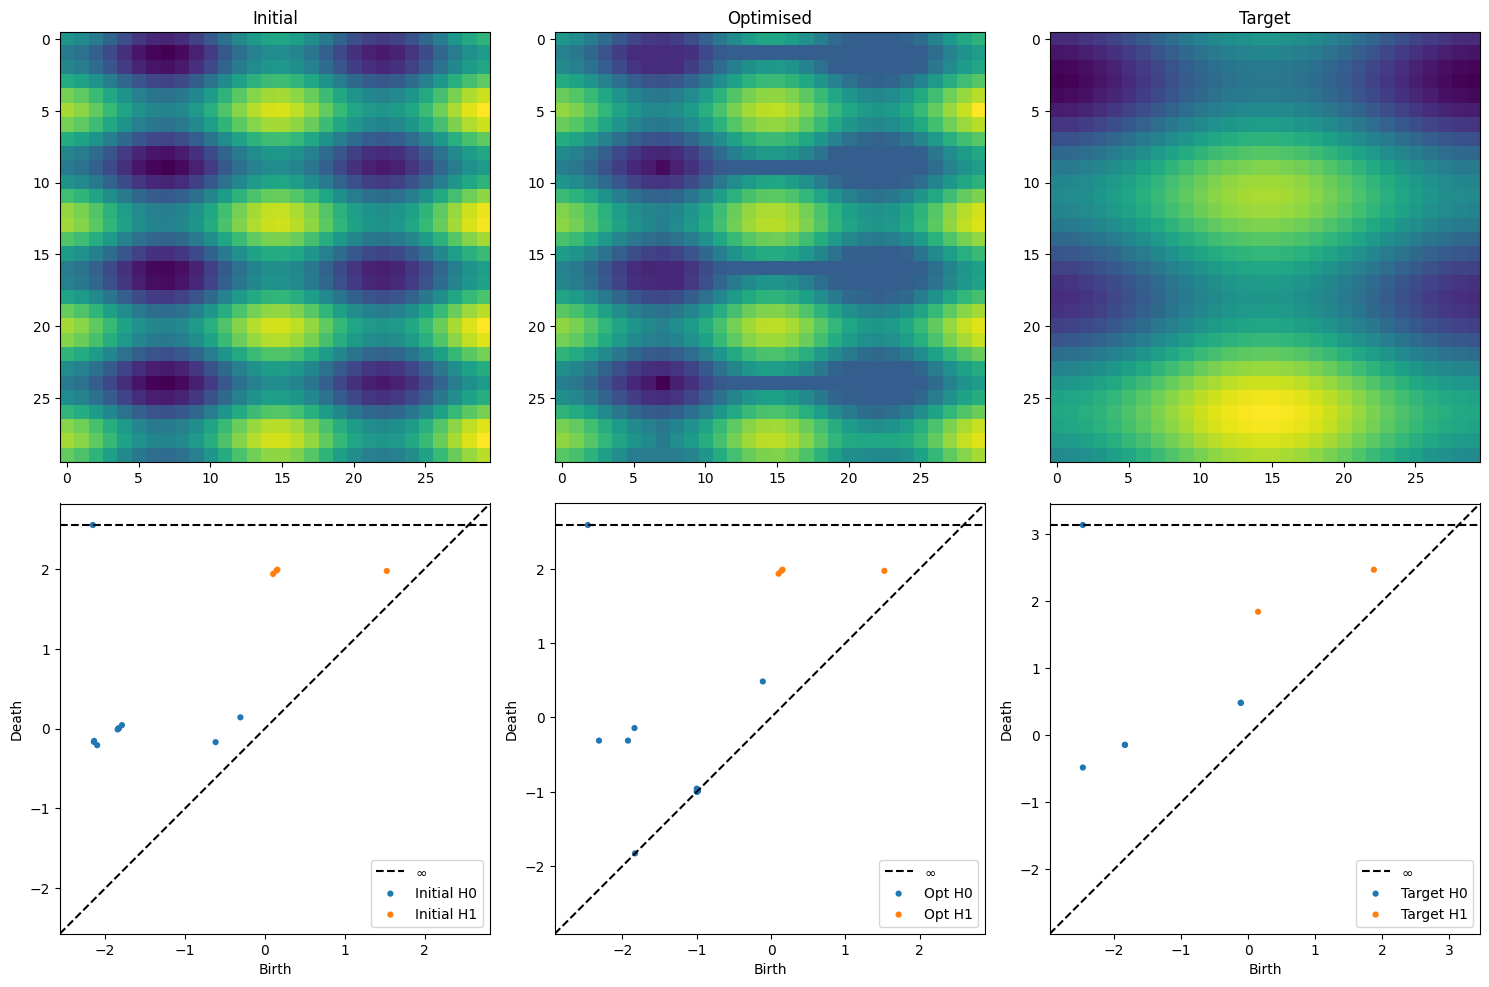

In [ ]:
# Plot results and persistence diagrams
fig, axs = plt.subplots(2, 3, figsize=(15, 10))  # 2 rows, 3 columns

# First row: Images
axs[0, 0].imshow(X_org)
axs[0, 0].set_title("Initial")
axs[0, 1].imshow(X)
axs[0, 1].set_title("Optimised")
axs[0, 2].imshow(Y)
axs[0, 2].set_title("Target")

# Second row: Persistence diagrams
# Initial persistence diagram
PH_X_org = cripser.computePH(X_org)
PH_X_org = [PH_X_org[PH_X_org[:, 0] == i, 1:3] for i in range(2)]
persim.plot_diagrams(PH_X_org, labels=["Initial H0", "Initial H1"], ax=axs[1, 0])

# Optimized persistence diagram
PH_X = cripser.computePH(X)
PH_X = [PH_X[PH_X[:, 0] == i, 1:3] for i in range(2)]
persim.plot_diagrams(PH_X, labels=["Opt H0", "Opt H1"], ax=axs[1, 1])

# Target persistence diagram
PH_Y = cripser.computePH(Y)
PH_Y = [PH_Y[PH_Y[:, 0] == i, 1:3] for i in range(2)]
persim.plot_diagrams(PH_Y, labels=["Target H0", "Target H1"], ax=axs[1, 2])

# Adjust layout and display
plt.tight_layout()
plt.show()

## PH regularised MDS

[PersistenceInformation(pairing=array([[69, 60, 36,  4]]), diagram=tensor([[0.2705, 1.7349]]), dimension=1)]


C:\Users\user\AppData\Local\Temp\ipykernel_17584\2045052724.py:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  X = X + np.random.normal(scale=noise, size=X.shape)


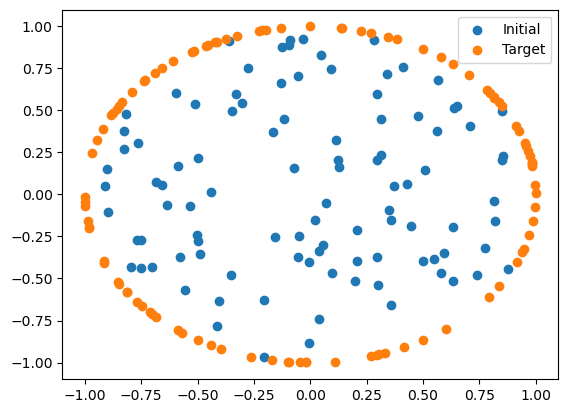

In [ ]:
#### settings
n_points=100
noise=0
dim = 2
min_dim = 1 # PH of dimensions from min_dim to dim-1 will be used for computing PH loss
p,q = 2,2 # parameters for Wasserstein
seed = 42 # random seed

#target_PH_source = "manual" # ["pointcloud","manual"]
#target_PH = [[1,2], [1,2]] # [[brith,death],[birth,death],...]
target_PH_source = "pointcloud"     ## target PH from another point cloud Y

###############
cpx = VietorisRipsComplex(dim=dim)
#cpx = AlphaComplex()
loss_fn = WassersteinDistance(p=p,q=q)
#loss_fn = SummaryStatisticLoss(summary_statistic=statistic, p=2, q=2)
selector = SelectByDimension(min_dim=min_dim, max_dim=dim-1)

## create initial point cloud: this will be optimised
if dim==2:
    X= sample_from_disk(n=n_points, r=0, seed=seed).float()
else:
    X = sample_from_sphere(n=n_points, d=dim-1, seed=seed).float()

# add noise
X = X + np.random.normal(scale=noise, size=X.shape)
plt.scatter(X[:, 0], X[:, 1], label='Initial')

## initial point cloud
X = torch.as_tensor(X, dtype=torch.float, device=device)
X = torch.nn.Parameter(X, requires_grad=True).to(device)

## target point cloud
Y = sample_from_sphere(n=n_points, d=1)  # target point cloud
plt.scatter(Y[:, 0], Y[:, 1], label='Target')
Y = torch.as_tensor(Y, dtype=torch.float, device=device)
cdist = torch.cdist(Y,Y,p=2)

## setting target PH
if target_PH_source=="manual":
    persistence_diagram = torch.tensor(target_PH, dtype=torch.float32, device=device)
    pi_target = [PersistenceInformation(torch.zeros((persistence_diagram.shape[0],4),dtype=torch.long), persistence_diagram, 1)]
elif target_PH_source=="pointcloud":
    pi_target = cpx(Y)
else:
    print("specify target PH")

pi_target = selector(pi_target)
plt.legend()
plt.show()

In [ ]:
## optimise embedding

n_iterations = 1000
disp_interval = 50

lambda_dist = 0.2 # weight for distance matrix matching. NOTE: setting this to 0 means purely PH optimisation.
lambda_PH = 0.5 # weight for PH. NOTE: setting this to 0 successfully recovers the target point cloud.

ph_loss_type="total_h1_life" # ["wasserstein"]
#ph_loss_type="wasserstein"

## choose lr carefully!
lr = 1e-1 # 1e-1 -- 1e-3
#opt = optim.SGD([X], lr=0.1)
opt = optim.Adam([X], lr=lr, weight_decay=0)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, 'min')

## optimisation iteration
loss_dist = torch.zeros(1, device=device)
loss_ph = torch.zeros(1, device=device)
progress = tqdm(range(n_iterations))

# plots
fig_L,axs_L = plt.subplots(1,1,figsize=(8,5))
disp_L = display(fig_L,display_id=True)
losses = {"PH":[], "dist":[], "lr":[]}

for i in progress:
    if lambda_PH>0:
        pi_source = selector(cpx(X))
        if ph_loss_type=="total_h1_life":
            loss_ph = -pi_source[0].diagram.diff().sum() # total life of PH1
        else:
            loss_ph = loss_fn(pi_source, pi_target) # wasserstein dist
        #loss = -loss_fn(pi_source)
    if lambda_dist>0:
        loss_dist = ((torch.cdist(X,Y,p=2)-cdist)**2).mean()

    loss = lambda_PH*loss_ph + lambda_dist*loss_dist
    opt.zero_grad()
    loss.backward()
    opt.step()
    scheduler.step(loss)
    losses["PH"].append(loss_ph.item())
    losses["dist"].append(loss_dist.item())
    losses["lr"].append(scheduler.get_last_lr()[0])

    if i%disp_interval==0:
        plot_loss(losses,ax=axs_L)
        disp_L.update(fig_L)

    progress.set_postfix(loss=f'{loss.item():.08f}')

plt.close('all')

  0%|          | 0/1000 [00:00<?, ?it/s]

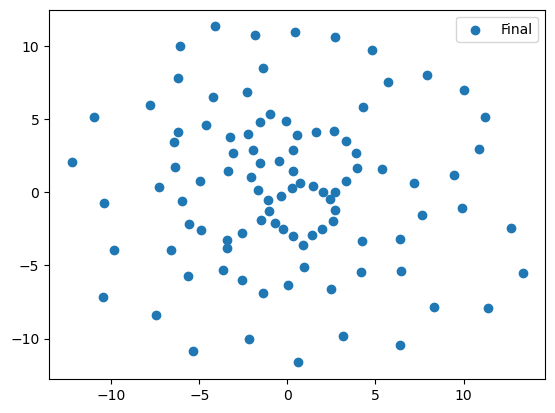

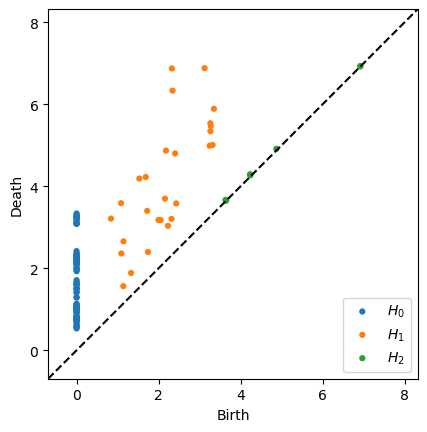

In [ ]:
## plot final embedding
Z = X.cpu().detach().numpy()
plt.scatter(Z[:, 0], Z[:, 1], label='Final')
plt.legend()
plt.show()
ccp = cpx(X)
diag = torch2ripser(ccp)
persim.plot_diagrams(diag)
plt.show()


## PH regularised graph embedding

In [ ]:
## create graph using networkX
n_points=100
seed = 42 # random seed


##
selector = SelectByDimension(min_dim=1, max_dim=1) # we care only PH1
cpx = VietorisRipsComplex(dim=2)
p,q = 2,2 # parameters for Wasserstein
loss_fn = WassersteinDistance(p=p,q=q)

###
G = nx.cycle_graph(n_points)
G.remove_edge(0,n_points-1) # missing edge
src = torch.tensor([i for i,j in G.edges], dtype=torch.long, device=device)
dst = torch.tensor([j for i,j in G.edges], dtype=torch.long, device=device)
weights = torch.ones(len(G.edges), dtype=torch.float32, device=device)
nx.draw(G)


In [ ]:
## Initialise embedding
initialisation = "incomplete_circle"  # ["incomplete_circle", "random", "torocoid"]

def initialise_embedding(initialisation, n_points, seed, G):
    if initialisation == "random":
        # Random initialisation within a disk
        X = sample_from_disk(n=n_points, r=0, R=1, seed=seed)
    elif initialisation == "incomplete_circle":
        # Synthetic initialisation (incomplete circle)
        t = np.linspace(0, 2 * np.pi, n_points)
        s = 0.8
        r = n_points / (s * 2 * np.pi)
        X = r * np.vstack([np.cos(s * t), np.sin(s * t)]).T
    elif initialisation == "torocoid":
        # Synthetic initialisation (torocoid)
        t = np.linspace(0, 4 * np.pi, n_points) + np.pi / 2 + eps  # eps is to break symmetry
        a = 0.3
        X = np.vstack([a * t - np.cos(t), a - np.sin(t)]).T
        r = 1 / np.sqrt(((X[[i for i, j in G.edges]] - X[[j for i, j in G.edges]]) ** 2).sum(1)).mean()  # rescale
        X = r * X
    else:
        raise ValueError("Unknown initialisation method: {}".format(initialisation))
    return X

# Initialise embedding
X = initialise_embedding(initialisation, n_points, seed, G)

# Plot the initial embedding
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=range(len(X)), cmap='viridis', label='Initial Embedding')
plt.colorbar(label='Node Index')
plt.title('Initial Embedding')
plt.legend()
plt.show()

# Convert to tensor and set as parameter
X = torch.as_tensor(X, dtype=torch.float, device=device)
X = torch.nn.Parameter(X, requires_grad=True).to(device)


In [ ]:
## optimise embedding
lr = 1e-2 # 1e-1 -- 1e-3
opt = optim.Adam([X], lr=lr, weight_decay=0)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, 'min')
lambda_dist = 1
lambda_repel = 1
lambda_h1 = 1
batch_ratio = 1

loss_repel = torch.zeros(1, device=device)
loss_h1 = torch.zeros(1, device=device)

h1_loss_type = "wasserstein" # ["total_h1_life_max","total_h1_life_min","wasserstein"]
#h1_loss_type = "total_h1_life_min"

n_iterations = 2000

##
PH = [[1,n_points/np.pi]] # [[brith,death],[birth,death],...]
persistence_diagram = torch.tensor(PH, dtype=torch.float32, device=device)
pi_target = [PersistenceInformation(torch.zeros((persistence_diagram.shape[0],4),dtype=torch.long), persistence_diagram, 1)]
loss_fn = WassersteinDistance(p=p,q=q)
selector = SelectByDimension(min_dim=1, max_dim=1) # we care only PH1
###


progress = tqdm(range(n_iterations))
for i in progress:
    batch_edge = torch.randperm(int(batch_ratio*len(G.edges)))
    batch_vertex = torch.randperm(int(batch_ratio*len(G.nodes)))
    # distance
    loss_dist = ((((X[src[batch_edge]]-X[dst[batch_edge]])**2).sum(dim=1)-weights[batch_edge])**2).mean()

    if lambda_repel>0:
        # rnd_src = torch.randint(0,len(G.nodes),(num_neg_samples,))
        # rnd_dst = torch.randint(0,len(G.nodes),(num_neg_samples,))
        # loss_repel = (1.0/((X[src]-X[dst])**2+eps).sum(dim=1)).mean()
        loss_repel = (1.0/(torch.cdist(X[batch_vertex],X[batch_vertex],p=2)+eps)).mean()
        #loss_repel = torch.exp(-torch.cdist(X[batch_vertex],X[batch_vertex],p=2)).sum()

    if lambda_h1>0:
        pi_source = selector(cpx(X)) # select PH1
        if h1_loss_type=="total_h1_life_min":
            loss_h1 = pi_source[0].diagram.diff().sum() # total life of PH1
        elif h1_loss_type=="total_h1_life_max":
            loss_h1 = -pi_source[0].diagram.diff().sum() # total life of PH1
        elif h1_loss_type=="wasserstein":
            loss_h1 = loss_fn(pi_source,pi_target) # wasserstein
        else:
            life = pi_source[0].diagram.diff()
            target = torch.zeros((len(life),))
            target[0]=100
            #loss_h1 = ((torch.sort(life)[0]-target)**2).sum()
            loss_h1 = (life.max()-100)**2 + (life**2).mean()

    loss = lambda_dist * loss_dist + lambda_repel * loss_repel + lambda_h1 * loss_h1
    opt.zero_grad()
    loss.backward()
    opt.step()
#    scheduler.step(loss)

    progress.set_postfix(loss=f'{loss.item():.08f}, h1={loss_h1.item():.08f}')


In [ ]:
## plot results
Z = X.cpu().detach().numpy()
plt.scatter(Z[:, 0], Z[:, 1], c=range(len(Z)), label='Result')
plt.legend()
plt.show()
print("PH1", selector(cpx(X)))